In [1]:
# load offline trained agent
# load expert agent
# write ensemble class for offline trained agents
# use distributional RL to detect risky states
# use ensembles to detect novel states
# if novelty is above a treshold give control to expert 
# if risk is above a treshold give control to expert
# can conformal prediction give us guaranties about the performance in this setu?p
# empirecally verify if we are able to get the desired performance

In [1]:
import re
import os
import argparse
from copy import deepcopy
import torch
from torch import nn
import numpy as np
import gymnasium as gym
from types import SimpleNamespace
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

from examples.offline.utils import load_buffer_d4rl
from tianshou.policy import DSACPolicy, BasePolicy
from tianshou.data.buffer.vecbuf import VectorReplayBuffer, ReplayBuffer
from tianshou.env import SubprocVectorEnv
from tianshou.data import Collector, Batch, to_torch
from tianshou.data.types import RolloutBatchProtocol
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import ActorProb, QuantileMlp
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/shim

In [2]:
device = "cuda:3"
seed = 0
np.random.seed(seed);
torch.manual_seed(seed);

In [3]:
def parse_value(value):
    # Convert simple types (int, float, bool, None)
    if value.isdigit():
        return int(value)
    elif re.match(r'^\d+\.\d+$', value):
        return float(value)
    elif value == "True":
        return True
    elif value == "False":
        return False
    elif value == "None":
        return None
    elif value.startswith("[") and value.endswith("]"):
        # Convert the list items
        items = re.split(r',(?=[^\]]*(?:\[|$))', value[1:-1])
        return [parse_value(item.strip()) for item in items]
    elif value.startswith("(") and value.endswith(")"):
        # Convert the tuple items
        items = re.split(r',(?=[^\)]*(?:\(|$))', value[1:-1])
        # Special case for single-item tuple
        if len(items) == 2 and items[0].strip() != '':
            return (parse_value(items[0].strip()),)
        return tuple(parse_value(item.strip()) for item in items)
    elif value.startswith("'") and value.endswith("'"):
        return value[1:-1]
    # Else, return the value as-is
    return value

def get_args(event_file):
    ea = EventAccumulator(event_file)
    ea.Reload()  # Load the file
    # Get the text data
    texts = ea.Tags()["tensors"]
    # Extract the actual text content
    text_data = {}
    for tag in texts:
        events = ea.Tensors(tag)
        for event in events:
            # You can extract the wall_time and step if needed
            # wall_time, step, value = event.wall_time, event.step, event.text
            text_data[tag] = event.tensor_proto.string_val
    data = text_data['args/text_summary'][0]
    # Convert bytes to string
    data_str = data.decode('utf-8')
    # Remove the "Namespace(" prefix and the trailing ")"
    data_str = data_str[len("Namespace("):-1]
    # Split into key-value pairs
    key_values = re.split(r',(?=\s\w+=)', data_str)
    # Parse each key-value pair
    args_dict = {}
    for kv in key_values:
        key, value = kv.split('=', 1)
        key = key.strip()
        args_dict[key] = parse_value(value)
    args = SimpleNamespace(**args_dict)
    try:
        env = gym.make(args.task)
        target_entropy = -np.prod(env.action_space.shape)
        log_alpha = torch.zeros(1, requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    except Exception:
        pass
    return args

In [4]:
def get_dsac_args():
    args = argparse.Namespace(
        task="Walker2d-v2",
        risk_type="neutral",
        buffer_size=1000000,
        hidden_sizes=[256, 256, 256],
        actor_lr=1e-5,
        critic_lr=3e-5,
        gamma=0.99,
        tau=0.005,
        auto_alpha=True,
        alpha=0.55,
        alpha_lr=0.00003,
        start_timesteps=1,
        epoch=200,
        step_per_epoch=5000,
        step_per_collect=1,
        update_per_step=1,
        batch_size=256,
        training_num=1,
        test_num=10,
        distortion_param=0.75,
    )
    return args

In [5]:
def load_policy(args, path):
    env = gym.make(args.task)
    args.state_shape = env.observation_space.shape or env.observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n
    # model
    net_a = Net(args.state_shape, hidden_sizes=args.hidden_sizes, device=device)
    actor = ActorProb(
        net_a,
        args.action_shape,
        device=device,
        unbounded=True,
        conditioned_sigma=True,
    ).to(device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2 = QuantileMlp(hidden_sizes=args.hidden_sizes, input_size=args.state_shape[0] + args.action_shape[0], device=device).to(device)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    target_entropy = -np.prod(env.action_space.shape)
    if args.auto_alpha:
        log_alpha = torch.tensor([np.log(args.alpha)], requires_grad=True, device=device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        args.alpha = (target_entropy, log_alpha, alpha_optim)
    policy = DSACPolicy(
        actor,
        actor_optim,
        critic1,
        critic1_optim,
        critic2,
        critic2_optim,
        risk_type='wang',
        tau=args.tau,
        gamma=args.gamma,
        alpha=args.alpha,
        action_space=env.action_space,
        device=device,
        distortion_param=0.75,
    )
    dirname = os.path.dirname(path)
    if os.path.isfile(os.path.join(dirname, "actor.pth")):
        policy.actor.load_state_dict(torch.load(os.path.join(dirname, "actor.pth"), map_location=device))
        print("Loaded actor from: ", os.path.join(dirname, "actor.pth"))
    if os.path.isfile(os.path.join(dirname, "critic1.pth")):
        policy.critic1.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        policy.critic1_old.load_state_dict(torch.load(os.path.join(dirname, "critic1.pth"), map_location=device))
        print("Loaded critic1 from: ", os.path.join(dirname, "critic1.pth"))
    if os.path.isfile(os.path.join(dirname, "critic2.pth")):
        policy.critic2.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        policy.critic2_old.load_state_dict(torch.load(os.path.join(dirname, "critic2.pth"), map_location=device))
        print("Loaded critic2 from: ", os.path.join(dirname, "critic2.pth"))
    else:
        policy.load_state_dict(torch.load(path, map_location=device))
        print("Loaded agent from: ", path)
    return policy

def load_behavioral_crtitic(args, path):
    behavioral_critic = QuantileMlp(
        input_size=args.state_shape[0] + args.action_shape[0],
        hidden_sizes=args.hidden_sizes,
        device=device,
    ).to(device)
    behavioral_critic.load_state_dict(torch.load(path, map_location=device))
    return behavioral_critic

def get_model(log_path, type=None):
    if type == "behavioral":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'model.pth')
        policy = load_behavioral_crtitic(args, resume_path)
    elif type == "codac":
        files = os.listdir(log_path)
        event_file = [f for f in files if f.startswith('event')][0]
        full_path = os.path.join(log_path, event_file)
        args = get_args(full_path)
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    else:
        args = get_dsac_args()
        resume_path = os.path.join(log_path, 'policy.pth')
        policy = load_policy(args, resume_path)
    return policy

In [43]:
log_path1 = "/data/user/R901105/dev/log/Walker2d-v2/codac_bc/neutral/0/240209-113304"
offline_policy1 = get_model(log_path1)

Loaded actor from:  /data/user/R901105/dev/log/Walker2d-v2/codac_bc/neutral/0/240209-113304/actor.pth
Loaded critic1 from:  /data/user/R901105/dev/log/Walker2d-v2/codac_bc/neutral/0/240209-113304/critic1.pth
Loaded critic2 from:  /data/user/R901105/dev/log/Walker2d-v2/codac_bc/neutral/0/240209-113304/critic2.pth


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [7]:
log_path = "/data/user/R901105/dev/log/Walker2d-v2/dsac/neutral/0/240208-110918"
expert_policy = get_model(log_path)

Loaded agent from:  /data/user/R901105/dev/log/Walker2d-v2/dsac/neutral/0/240208-110918/policy.pth


/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(


In [8]:
task = "Walker2d-v2"
env_num = 20
env = gym.make(task)

In [44]:
offline_data = load_buffer_d4rl("walker2d-medium-v2")

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|██████████| 21/21 [00:02<00:00, 10.02it/s]


# give control to the expert policy based on epistemic and aleatoric uncertainties

In [45]:
class MixedPolicy(BasePolicy):
    def __init__(self, base_policy: BasePolicy, expert_policy: BasePolicy, action_space, id_data):
        super().__init__(action_space=action_space, action_scaling=True)
        self.base_policy = base_policy
        self.expert_policy = expert_policy
        self.update_kde(id_data)
        self.cede_ctrl_prob = 1

    def update_kde(self, id_data):
        self.kde = KernelDensity(kernel='gaussian', bandwidth=2).fit(id_data)
        self.density_threshold = np.percentile(self.kde.score_samples(id_data), 1)  

    def forward(self, batch: RolloutBatchProtocol, state=None, n_repeat=100, **kwargs):
        bsz = len(batch.obs)
        batch = to_torch(batch, dtype=torch.float32, device=device)
        self.base_policy.eval()
        self.expert_policy.eval()
        with torch.no_grad():
            expert_result = self.expert_policy(batch)
            base_result = self.base_policy(batch)
            expert_qvalues1 = self.expert_policy.critic1(batch.obs, expert_result.act)
            expert_qvalues2 = self.expert_policy.critic2(batch.obs, expert_result.act)
            expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
            base_qvalues1 = self.base_policy.critic1(batch.obs, base_result.act)
            base_qvalues2 = self.base_policy.critic2(batch.obs, base_result.act)
            base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)
        risky = base_qvalues[:, 0] < expert_qvalues[:, 0] 
        log_dens = self.kde.score_samples(batch.obs.cpu().numpy())
        novel = log_dens < self.density_threshold
        novel = to_torch(novel, dtype=torch.float32, device=device)
        cede_ctrl = torch.logical_or(risky, novel)
        # if bsz == 1:
        #     not_cede_ctrl = ~cede_ctrl * (torch.rand(1, device=device) >= self.cede_ctrl_prob)
        #     cede_ctrl = ~not_cede_ctrl
        cede_ctrl = cede_ctrl.unsqueeze(-1)
        actions = torch.where(cede_ctrl, expert_result.act.mean(0), base_result.act.mean(0))
        self.cede_ctrl_prob *= 0.9999
        return Batch(**{'act': actions, 'policy': Batch({'cede_ctrl': cede_ctrl, 'novel': novel, 'risky': risky})})

    def train(self, mode: bool = True) -> "MixedPolicy":
        self.base_policy.train(mode)
        return self
    
    def process_fn(self, batch: RolloutBatchProtocol, buffer: ReplayBuffer, indices: np.ndarray) -> RolloutBatchProtocol:
        return self.base_policy.process_fn(batch, buffer, indices)

    def learn(self, batch, **kwargs):
        cede_ctrl = batch.policy.cede_ctrl.cpu().squeeze()
        batch = batch[~cede_ctrl]
        info = self.base_policy.learn(batch)
        return info

# estimate novelty_threshold from the data

In [46]:
offline_batch, _ = offline_data.sample(5000)
mixed_policy = MixedPolicy(offline_policy1, expert_policy, env.action_space, offline_batch.obs)
mixed_policy.density_threshold

-35.91203348865096

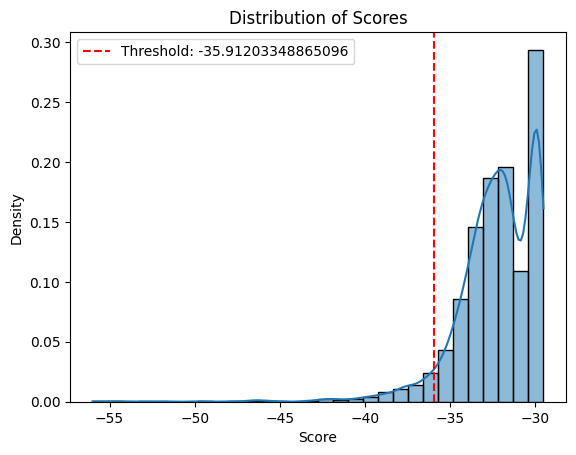

In [47]:
import seaborn as sns

# Assuming 'scores' and 'mixed_policy.density_threshold' are already defined
batch, _ = offline_data.sample(5000)
scores = mixed_policy.kde.score_samples(batch.obs)

# Plotting the distribution of scores
sns.histplot(scores, kde=True, stat="density", bins=30)
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Distribution of Scores")

# Adding a vertical line for the threshold
plt.axvline(x=mixed_policy.density_threshold, color='r', linestyle='--', label=f'Threshold: {mixed_policy.density_threshold}')

# Adding a legend
plt.legend()

# Show the plot
plt.show()

# perform continual learning and observe the evolution of numbers of calls to the expert

In [48]:
test_envs = SubprocVectorEnv([lambda: gym.make(task) for _ in range(5)])
test_envs.seed(seed);

/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/mujoco/mujoco_env.py:211: DeprecationWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Walker2d-v2 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(
/data/user/R901105/.conda/envs/dev/lib/python3.11/site-packages/gymnasi

In [49]:
test_buffer = VectorReplayBuffer(5000, 5)
train_collector = Collector(mixed_policy, env, offline_data)
test_collector = Collector(mixed_policy, test_envs, test_buffer)

/data/user/R901105/dev/my_fork/tianshou/tianshou/data/collector.py:70: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


In [50]:
def get_returns(policy, n, return_cede_ctrl=False):
    policy.eval()
    returns = []
    cede_ctrl = []
    novel = []
    risky = []
    for _ in range(n):
        obs, info = env.reset()
        done = False
        cum_reward = 0
        actions = []
        if return_cede_ctrl:
            cctrl_ep = []
            novel_ep = []
            risky_ep = []
        while not done:
            batch = Batch(obs=torch.from_numpy(np.expand_dims(obs, 0)).to(device), info=info)
            with torch.no_grad():
                result = policy(batch)
            act = result.act.cpu().squeeze().numpy()
            act = policy.map_action(act)
            if return_cede_ctrl:
                cctrl_ep.append(result.policy.cede_ctrl.cpu().squeeze().numpy())
                novel_ep.append(result.policy.novel.cpu().squeeze().numpy())
                risky_ep.append(result.policy.risky.cpu().squeeze().numpy())
            obs, reward, terminated, truncated, info = env.step(act)
            actions.append(act)
            cum_reward += reward
            done = terminated or truncated
        returns.append(cum_reward)
        if return_cede_ctrl:
            cede_ctrl.append(np.array(cctrl_ep).mean())
            novel.append(np.array(novel_ep).mean())
            risky.append(np.array(risky_ep).mean())
    if return_cede_ctrl:
        return np.array(returns).squeeze().mean(),  np.array(cede_ctrl).mean(), np.array(novel).mean(), np.array(risky).mean()
    return np.array(returns).squeeze().mean()

In [51]:
import datetime
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = os.path.join(task, "mixed", now)
log_path = os.path.join("../../log", log_name)
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

In [52]:
n = 2
expert_returns = get_returns(expert_policy, n)
def test_fn(num_epoch: int, step_idx: int):        
    returns, cede_ctrl, novel, risky = get_returns(mixed_policy, n, True)
    risky_returns = get_returns(offline_policy1, n)
    id_data = offline_data.sample(5000)[0].obs
    mixed_policy.update_kde(id_data)
    print("Mixed return: ", returns, "Suboptimal return: ", risky_returns, "Expert return: ", expert_returns, "Cede Control: ", cede_ctrl, "novel: ", novel, "risky: ", risky)
    # Log data to TensorBoard
    writer.add_scalar("Stats/Mixed return", returns, global_step=step_idx)
    writer.add_scalar("Stats/Suboptimal return", risky_returns, global_step=step_idx)
    writer.add_scalar("Stats/Expert return", expert_returns, global_step=step_idx)
    writer.add_scalar("Stats/Cede Control", cede_ctrl, global_step=step_idx)
    writer.add_scalar("Stats/Novel", novel, global_step=step_idx)
    writer.add_scalar("Stats/Risky", risky, global_step=step_idx)

In [53]:
from tianshou.trainer import OffpolicyTrainer

result = OffpolicyTrainer(
    policy=mixed_policy,
    train_collector=train_collector,
    test_collector=test_collector,
    test_fn=test_fn,
    max_epoch=200,
    step_per_epoch=1000,
    step_per_collect=1,
    episode_per_test=1,
    batch_size=512,
    logger=logger,
    update_per_step=1,
    test_in_train=False,
).run()

Mixed return:  5479.280775357426 Suboptimal return:  1882.6742232134595 Expert return:  5484.666977217041 Cede Control:  1.0 novel:  0.5325 risky:  1.0


Epoch #1: 1001it [00:28, 34.90it/s, alpha=0.535, env_step=1000, gradient_step=1000, len=1, loss/actor=-307.446, loss/alpha=-6.294, loss/critic1=6.520, loss/critic2=6.520, n/ep=0, n/st=1, rew=5.19]                          


Mixed return:  5477.6556531628385 Suboptimal return:  3159.09801710816 Expert return:  5484.666977217041 Cede Control:  1.0 novel:  0.53199995 risky:  1.0
Epoch #1: test_reward: 5458.437909 ± 0.000000, best_reward: 5473.537862 ± 0.000000 in #0


Epoch #2: 1001it [00:28, 35.28it/s, alpha=0.510, env_step=2000, gradient_step=2000, len=1000, loss/actor=-337.516, loss/alpha=-11.844, loss/critic1=6.028, loss/critic2=6.028, n/ep=0, n/st=1, rew=5482.43]                          


Mixed return:  5493.696176935122 Suboptimal return:  3886.9448967427033 Expert return:  5484.666977217041 Cede Control:  1.0 novel:  0.521 risky:  1.0
Epoch #2: test_reward: 5463.298374 ± 0.000000, best_reward: 5473.537862 ± 0.000000 in #0


Epoch #3: 1001it [00:28, 35.64it/s, alpha=0.493, env_step=3000, gradient_step=3000, len=1000, loss/actor=-364.113, loss/alpha=-12.663, loss/critic1=5.692, loss/critic2=5.690, n/ep=0, n/st=1, rew=5487.99]                          


Mixed return:  5487.903016870629 Suboptimal return:  846.7577418378121 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.51049995 risky:  0.999
Epoch #3: test_reward: 5471.579620 ± 0.000000, best_reward: 5473.537862 ± 0.000000 in #0


Epoch #4: 1001it [00:28, 34.80it/s, alpha=0.478, env_step=4000, gradient_step=4000, len=1000, loss/actor=-387.361, loss/alpha=-13.311, loss/critic1=5.467, loss/critic2=5.467, n/ep=0, n/st=1, rew=5478.55]                          


Mixed return:  5484.625436108497 Suboptimal return:  380.756112676464 Expert return:  5484.666977217041 Cede Control:  0.9795 novel:  0.34149998 risky:  0.977
Epoch #4: test_reward: 5483.602743 ± 0.000000, best_reward: 5483.602743 ± 0.000000 in #4


Epoch #5: 1001it [00:28, 35.15it/s, alpha=0.464, env_step=5000, gradient_step=5000, len=1000, loss/actor=-410.103, loss/alpha=-13.929, loss/critic1=5.281, loss/critic2=5.280, n/ep=0, n/st=1, rew=5488.83]                          


Mixed return:  5480.0497340383035 Suboptimal return:  761.570649477945 Expert return:  5484.666977217041 Cede Control:  0.98 novel:  0.391 risky:  0.977
Epoch #5: test_reward: 5488.081055 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #6: 1001it [00:28, 35.44it/s, alpha=0.450, env_step=6000, gradient_step=6000, len=1000, loss/actor=-430.850, loss/alpha=-14.533, loss/critic1=5.112, loss/critic2=5.115, n/ep=0, n/st=1, rew=5491.76]                          


Mixed return:  5491.317005273093 Suboptimal return:  2242.4942325072716 Expert return:  5484.666977217041 Cede Control:  0.979 novel:  0.4005 risky:  0.9744999999999999
Epoch #6: test_reward: 5481.026814 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #7: 1001it [00:28, 35.15it/s, alpha=0.436, env_step=7000, gradient_step=7000, len=1000, loss/actor=-449.473, loss/alpha=-15.117, loss/critic1=4.951, loss/critic2=4.953, n/ep=0, n/st=1, rew=5484.54]                          


Mixed return:  5307.398244388795 Suboptimal return:  3696.448621402508 Expert return:  5484.666977217041 Cede Control:  0.891 novel:  0.3325 risky:  0.881
Epoch #7: test_reward: 5485.352036 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #8: 1001it [00:28, 35.03it/s, alpha=0.424, env_step=8000, gradient_step=8000, len=705, loss/actor=-467.013, loss/alpha=-15.701, loss/critic1=4.807, loss/critic2=4.806, n/ep=0, n/st=1, rew=2678.32]                          


Mixed return:  5473.808925412541 Suboptimal return:  3502.295117909986 Expert return:  5484.666977217041 Cede Control:  0.969 novel:  0.3375 risky:  0.961
Epoch #8: test_reward: 5478.519321 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #9: 1001it [00:28, 35.03it/s, alpha=0.411, env_step=9000, gradient_step=9000, len=295, loss/actor=-483.609, loss/alpha=-16.301, loss/critic1=4.616, loss/critic2=4.619, n/ep=0, n/st=1, rew=1225.24]                          


Mixed return:  4957.416573492732 Suboptimal return:  3453.3146658334317 Expert return:  5484.666977217041 Cede Control:  0.767 novel:  0.265 risky:  0.753
Epoch #9: test_reward: 4768.954769 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #10: 1001it [00:28, 35.30it/s, alpha=0.399, env_step=10000, gradient_step=10000, len=1000, loss/actor=-498.113, loss/alpha=-16.848, loss/critic1=4.482, loss/critic2=4.483, n/ep=0, n/st=1, rew=5471.55]                          


Mixed return:  4614.592079934448 Suboptimal return:  3504.554934471539 Expert return:  5484.666977217041 Cede Control:  0.6595 novel:  0.3055 risky:  0.6355
Epoch #10: test_reward: 5022.437282 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #11: 1001it [00:28, 34.93it/s, alpha=0.387, env_step=11000, gradient_step=11000, len=1000, loss/actor=-512.767, loss/alpha=-17.488, loss/critic1=4.213, loss/critic2=4.215, n/ep=0, n/st=1, rew=4589.75]                          


Mixed return:  5157.414891315244 Suboptimal return:  3516.5137879729728 Expert return:  5484.666977217041 Cede Control:  0.8614999999999999 novel:  0.28100002 risky:  0.839
Epoch #11: test_reward: 4432.859201 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #12: 1001it [00:28, 35.42it/s, alpha=0.376, env_step=12000, gradient_step=12000, len=1000, loss/actor=-524.964, loss/alpha=-18.046, loss/critic1=4.017, loss/critic2=4.021, n/ep=0, n/st=1, rew=5043.64]                          


Mixed return:  4207.824858916543 Suboptimal return:  3463.6436640275388 Expert return:  5484.666977217041 Cede Control:  0.431 novel:  0.1585 risky:  0.40549999999999997
Epoch #12: test_reward: 4805.911825 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #13: 1001it [00:28, 34.86it/s, alpha=0.364, env_step=13000, gradient_step=13000, len=1000, loss/actor=-537.062, loss/alpha=-18.618, loss/critic1=3.813, loss/critic2=3.817, n/ep=0, n/st=1, rew=4718.38]                          


Mixed return:  3664.535927088316 Suboptimal return:  3462.0608368203575 Expert return:  5484.666977217041 Cede Control:  0.2335 novel:  0.144 risky:  0.2145
Epoch #13: test_reward: 3824.597746 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #14: 1001it [00:28, 35.58it/s, alpha=0.354, env_step=14000, gradient_step=14000, len=1000, loss/actor=-547.486, loss/alpha=-19.208, loss/critic1=3.606, loss/critic2=3.606, n/ep=0, n/st=1, rew=5137.03]                          


Mixed return:  4082.822608596711 Suboptimal return:  3441.922993886362 Expert return:  5484.666977217041 Cede Control:  0.39849999999999997 novel:  0.1765 risky:  0.364
Epoch #14: test_reward: 3832.519958 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #15: 1001it [00:29, 33.88it/s, alpha=0.343, env_step=15000, gradient_step=15000, len=1000, loss/actor=-557.581, loss/alpha=-19.800, loss/critic1=3.395, loss/critic2=3.396, n/ep=0, n/st=1, rew=3357.73]                          


Mixed return:  1970.95780638322 Suboptimal return:  3471.1764878801623 Expert return:  5484.666977217041 Cede Control:  0.15637828407224957 novel:  0.13557062 risky:  0.10551792556102901
Epoch #15: test_reward: 3450.815291 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #16: 1001it [00:28, 35.51it/s, alpha=0.333, env_step=16000, gradient_step=16000, len=1000, loss/actor=-565.619, loss/alpha=-20.355, loss/critic1=3.246, loss/critic2=3.246, n/ep=0, n/st=1, rew=4099.75]                          


Mixed return:  1165.7682058302398 Suboptimal return:  3440.3922649984806 Expert return:  5484.666977217041 Cede Control:  0.180545817006943 novel:  0.17407712 risky:  0.10589124905478792
Epoch #16: test_reward: 3608.698653 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #17: 1001it [00:28, 35.33it/s, alpha=0.323, env_step=17000, gradient_step=17000, len=379, loss/actor=-573.691, loss/alpha=-20.938, loss/critic1=3.050, loss/critic2=3.050, n/ep=0, n/st=1, rew=1199.69]                          


Mixed return:  2081.5797406755514 Suboptimal return:  3427.107305215346 Expert return:  5484.666977217041 Cede Control:  0.21286734693877551 novel:  0.19111225 risky:  0.12759183673469388
Epoch #17: test_reward: 3635.554814 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #18: 1001it [00:28, 35.27it/s, alpha=0.314, env_step=18000, gradient_step=18000, len=621, loss/actor=-581.296, loss/alpha=-21.493, loss/critic1=2.873, loss/critic2=2.876, n/ep=0, n/st=1, rew=2124.65]                          


Mixed return:  1105.035096198134 Suboptimal return:  3394.952686767622 Expert return:  5484.666977217041 Cede Control:  0.5929608188606427 novel:  0.44082975 risky:  0.49406409933719275
Epoch #18: test_reward: 4008.129201 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #19: 1001it [00:28, 35.66it/s, alpha=0.304, env_step=19000, gradient_step=19000, len=1000, loss/actor=-587.047, loss/alpha=-22.014, loss/critic1=2.737, loss/critic2=2.740, n/ep=0, n/st=1, rew=3572.94]                          


Mixed return:  3438.184638007665 Suboptimal return:  3446.3955720369077 Expert return:  5484.666977217041 Cede Control:  0.048 novel:  0.0435 risky:  0.0245
Epoch #19: test_reward: 3724.170564 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #20: 1001it [00:28, 35.42it/s, alpha=0.295, env_step=20000, gradient_step=20000, len=1000, loss/actor=-592.368, loss/alpha=-22.600, loss/critic1=2.580, loss/critic2=2.581, n/ep=0, n/st=1, rew=3381.40]                          


Mixed return:  3446.2773576659847 Suboptimal return:  3396.9284955611306 Expert return:  5484.666977217041 Cede Control:  0.0195 novel:  0.0195 risky:  0.0
Epoch #20: test_reward: 3403.949776 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #21: 1001it [00:30, 32.30it/s, alpha=0.287, env_step=21000, gradient_step=21000, len=1000, loss/actor=-597.193, loss/alpha=-23.197, loss/critic1=2.447, loss/critic2=2.449, n/ep=0, n/st=1, rew=3440.12]                          


Mixed return:  4246.443977068811 Suboptimal return:  3457.3161326527343 Expert return:  5484.666977217041 Cede Control:  0.3885 novel:  0.1405 risky:  0.3485
Epoch #21: test_reward: 4761.400513 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #22: 1001it [00:28, 35.31it/s, alpha=0.278, env_step=22000, gradient_step=22000, len=1000, loss/actor=-600.157, loss/alpha=-23.648, loss/critic1=2.359, loss/critic2=2.361, n/ep=0, n/st=1, rew=3592.61]                          


Mixed return:  4257.685382679047 Suboptimal return:  3469.8802267204073 Expert return:  5484.666977217041 Cede Control:  0.426 novel:  0.19 risky:  0.398
Epoch #22: test_reward: 4713.731214 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #23: 1001it [00:28, 34.71it/s, alpha=0.270, env_step=23000, gradient_step=23000, len=1000, loss/actor=-603.130, loss/alpha=-24.280, loss/critic1=2.259, loss/critic2=2.258, n/ep=0, n/st=1, rew=3467.99]                          


Mixed return:  3608.5316857190846 Suboptimal return:  3502.450787518992 Expert return:  5484.666977217041 Cede Control:  0.1295 novel:  0.0905 risky:  0.0845
Epoch #23: test_reward: 3542.247307 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #24: 1001it [00:28, 35.33it/s, alpha=0.262, env_step=24000, gradient_step=24000, len=167, loss/actor=-606.895, loss/alpha=-24.837, loss/critic1=2.120, loss/critic2=2.120, n/ep=0, n/st=1, rew=407.55]                           


Mixed return:  4236.27828076136 Suboptimal return:  3535.465526743872 Expert return:  5484.666977217041 Cede Control:  0.3925 novel:  0.1615 risky:  0.351
Epoch #24: test_reward: 3403.480677 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #25: 1001it [00:28, 35.37it/s, alpha=0.254, env_step=25000, gradient_step=25000, len=833, loss/actor=-607.752, loss/alpha=-25.335, loss/critic1=2.032, loss/critic2=2.030, n/ep=0, n/st=1, rew=3112.79]                          


Mixed return:  3404.1566275906553 Suboptimal return:  3420.081357804167 Expert return:  5484.666977217041 Cede Control:  0.014 novel:  0.014 risky:  0.0
Epoch #25: test_reward: 3558.897790 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #26: 1001it [00:28, 35.26it/s, alpha=0.247, env_step=26000, gradient_step=26000, len=1000, loss/actor=-610.141, loss/alpha=-26.008, loss/critic1=1.885, loss/critic2=1.885, n/ep=0, n/st=1, rew=3407.89]                          


Mixed return:  3505.262970739672 Suboptimal return:  3457.7233261254796 Expert return:  5484.666977217041 Cede Control:  0.015 novel:  0.015000001 risky:  0.0
Epoch #26: test_reward: 3435.949187 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #27: 1001it [00:28, 35.38it/s, alpha=0.239, env_step=27000, gradient_step=27000, len=1000, loss/actor=-611.314, loss/alpha=-26.549, loss/critic1=1.831, loss/critic2=1.831, n/ep=0, n/st=1, rew=3421.59]                          


Mixed return:  3452.9788988167193 Suboptimal return:  3568.1363537730854 Expert return:  5484.666977217041 Cede Control:  0.0135 novel:  0.0135 risky:  0.0
Epoch #27: test_reward: 3419.135871 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #28: 1001it [00:28, 35.00it/s, alpha=0.232, env_step=28000, gradient_step=28000, len=1000, loss/actor=-611.690, loss/alpha=-27.120, loss/critic1=1.754, loss/critic2=1.755, n/ep=0, n/st=1, rew=3426.72]                          


Mixed return:  3546.644795916325 Suboptimal return:  3602.5090747967483 Expert return:  5484.666977217041 Cede Control:  0.0335 novel:  0.0335 risky:  0.0005
Epoch #28: test_reward: 3653.944100 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #29: 1001it [00:28, 34.62it/s, alpha=0.225, env_step=29000, gradient_step=29000, len=1000, loss/actor=-612.142, loss/alpha=-27.681, loss/critic1=1.664, loss/critic2=1.666, n/ep=0, n/st=1, rew=3435.98]                          


Mixed return:  3625.8755113114394 Suboptimal return:  3624.76656920057 Expert return:  5484.666977217041 Cede Control:  0.0525 novel:  0.038 risky:  0.0295
Epoch #29: test_reward: 3804.025647 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #30: 1001it [00:28, 34.82it/s, alpha=0.219, env_step=30000, gradient_step=30000, len=1000, loss/actor=-611.374, loss/alpha=-28.214, loss/critic1=1.633, loss/critic2=1.635, n/ep=0, n/st=1, rew=3745.77]                          


Mixed return:  3696.219289994184 Suboptimal return:  3650.418961915112 Expert return:  5484.666977217041 Cede Control:  0.026999999999999996 novel:  0.026999999 risky:  0.0
Epoch #30: test_reward: 3598.052773 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #31: 1001it [00:28, 34.80it/s, alpha=0.212, env_step=31000, gradient_step=31000, len=1000, loss/actor=-611.156, loss/alpha=-28.715, loss/critic1=1.578, loss/critic2=1.579, n/ep=0, n/st=1, rew=3747.05]                          


Mixed return:  3760.680567739293 Suboptimal return:  3730.885611928807 Expert return:  5484.666977217041 Cede Control:  0.061 novel:  0.054 risky:  0.0325
Epoch #31: test_reward: 3638.534065 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #32: 1001it [00:28, 34.99it/s, alpha=0.206, env_step=32000, gradient_step=32000, len=1000, loss/actor=-610.499, loss/alpha=-29.222, loss/critic1=1.532, loss/critic2=1.532, n/ep=0, n/st=1, rew=3622.61]                          


Mixed return:  3802.0164655966046 Suboptimal return:  3721.506305204487 Expert return:  5484.666977217041 Cede Control:  0.129 novel:  0.10250001 risky:  0.072
Epoch #32: test_reward: 2861.384334 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #33: 1001it [00:28, 35.55it/s, alpha=0.200, env_step=33000, gradient_step=33000, len=1000, loss/actor=-609.546, loss/alpha=-29.850, loss/critic1=1.480, loss/critic2=1.478, n/ep=0, n/st=1, rew=3770.87]                          


Mixed return:  3809.6130619695514 Suboptimal return:  3768.509938029864 Expert return:  5484.666977217041 Cede Control:  0.024999999999999998 novel:  0.024999999 risky:  0.0
Epoch #33: test_reward: 3723.097712 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #34: 1001it [00:28, 35.27it/s, alpha=0.194, env_step=34000, gradient_step=34000, len=1000, loss/actor=-607.650, loss/alpha=-30.332, loss/critic1=1.468, loss/critic2=1.467, n/ep=0, n/st=1, rew=3891.31]                          


Mixed return:  3820.4414312312183 Suboptimal return:  3739.0006762737776 Expert return:  5484.666977217041 Cede Control:  0.1065 novel:  0.089 risky:  0.054
Epoch #34: test_reward: 3986.410716 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #35: 1001it [00:28, 35.56it/s, alpha=0.188, env_step=35000, gradient_step=35000, len=1000, loss/actor=-606.255, loss/alpha=-30.912, loss/critic1=1.409, loss/critic2=1.408, n/ep=0, n/st=1, rew=3723.97]                          


Mixed return:  3806.526679024716 Suboptimal return:  3800.2671761440406 Expert return:  5484.666977217041 Cede Control:  0.042 novel:  0.038999997 risky:  0.0095
Epoch #35: test_reward: 3836.406362 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #36: 1001it [00:28, 35.12it/s, alpha=0.183, env_step=36000, gradient_step=36000, len=1000, loss/actor=-603.961, loss/alpha=-31.370, loss/critic1=1.405, loss/critic2=1.407, n/ep=0, n/st=1, rew=4039.49]                          


Mixed return:  3831.61164133665 Suboptimal return:  3790.336933876615 Expert return:  5484.666977217041 Cede Control:  0.07400000000000001 novel:  0.0585 risky:  0.0475
Epoch #36: test_reward: 3799.141986 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #37: 1001it [00:28, 34.82it/s, alpha=0.177, env_step=37000, gradient_step=37000, len=1000, loss/actor=-603.234, loss/alpha=-31.692, loss/critic1=1.408, loss/critic2=1.409, n/ep=0, n/st=1, rew=3726.10]                          


Mixed return:  3860.215037600804 Suboptimal return:  3803.995196580275 Expert return:  5484.666977217041 Cede Control:  0.0475 novel:  0.0455 risky:  0.006
Epoch #37: test_reward: 3803.083059 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #38: 1001it [00:28, 35.00it/s, alpha=0.172, env_step=38000, gradient_step=38000, len=1000, loss/actor=-600.750, loss/alpha=-32.187, loss/critic1=1.421, loss/critic2=1.423, n/ep=0, n/st=1, rew=3944.58]                          


Mixed return:  3909.949689397419 Suboptimal return:  3840.2603089830886 Expert return:  5484.666977217041 Cede Control:  0.1705 novel:  0.125 risky:  0.131
Epoch #38: test_reward: 3266.127927 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #39: 1001it [00:28, 34.68it/s, alpha=0.167, env_step=39000, gradient_step=39000, len=911, loss/actor=-598.961, loss/alpha=-32.738, loss/critic1=1.435, loss/critic2=1.437, n/ep=0, n/st=1, rew=3368.38]                          


Mixed return:  2899.5446649271635 Suboptimal return:  3810.733316751935 Expert return:  5484.666977217041 Cede Control:  0.23243957364299256 novel:  0.20446394 risky:  0.18019357298827626
Epoch #39: test_reward: 3939.052679 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #40: 1001it [00:28, 35.20it/s, alpha=0.162, env_step=40000, gradient_step=40000, len=89, loss/actor=-598.218, loss/alpha=-33.259, loss/critic1=1.383, loss/critic2=1.384, n/ep=0, n/st=1, rew=163.39]                          


Mixed return:  3518.992799631121 Suboptimal return:  3795.7825968336356 Expert return:  5484.666977217041 Cede Control:  0.15545808383233534 novel:  0.13649401 risky:  0.08356586826347305
Epoch #40: test_reward: 3918.148759 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #41: 1001it [00:28, 35.56it/s, alpha=0.157, env_step=41000, gradient_step=41000, len=1000, loss/actor=-595.377, loss/alpha=-33.755, loss/critic1=1.378, loss/critic2=1.380, n/ep=0, n/st=1, rew=4089.93]                          


Mixed return:  3997.4901000083464 Suboptimal return:  3822.894235286002 Expert return:  5484.666977217041 Cede Control:  0.1735 novel:  0.116 risky:  0.09999999999999999
Epoch #41: test_reward: 3994.271830 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #42: 1001it [00:28, 35.54it/s, alpha=0.153, env_step=42000, gradient_step=42000, len=1000, loss/actor=-593.616, loss/alpha=-34.334, loss/critic1=1.320, loss/critic2=1.325, n/ep=0, n/st=1, rew=4011.68]                          


Mixed return:  3915.6559252024117 Suboptimal return:  3833.325963156197 Expert return:  5484.666977217041 Cede Control:  0.11 novel:  0.100999996 risky:  0.081
Epoch #42: test_reward: 3972.367086 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #43: 1001it [00:29, 34.16it/s, alpha=0.148, env_step=43000, gradient_step=43000, len=919, loss/actor=-591.068, loss/alpha=-34.768, loss/critic1=1.336, loss/critic2=1.335, n/ep=0, n/st=1, rew=3747.79]                          


Mixed return:  3901.3496831975235 Suboptimal return:  3844.9725384493236 Expert return:  5484.666977217041 Cede Control:  0.20700000000000002 novel:  0.16049999 risky:  0.14150000000000001
Epoch #43: test_reward: 3959.585803 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #44: 1001it [00:29, 33.78it/s, alpha=0.144, env_step=44000, gradient_step=44000, len=81, loss/actor=-587.913, loss/alpha=-35.316, loss/critic1=1.296, loss/critic2=1.297, n/ep=0, n/st=1, rew=143.72]                          


Mixed return:  4158.27296224732 Suboptimal return:  3855.4071575173266 Expert return:  5484.666977217041 Cede Control:  0.2575 novel:  0.1925 risky:  0.16449999999999998
Epoch #44: test_reward: 4137.188138 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #45: 1001it [00:28, 35.44it/s, alpha=0.140, env_step=45000, gradient_step=45000, len=1000, loss/actor=-585.288, loss/alpha=-35.854, loss/critic1=1.244, loss/critic2=1.244, n/ep=0, n/st=1, rew=4014.49]                          


Mixed return:  4027.5063278162625 Suboptimal return:  3910.199462205501 Expert return:  5484.666977217041 Cede Control:  0.313 novel:  0.235 risky:  0.2145
Epoch #45: test_reward: 1786.588110 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #46: 1001it [00:27, 35.95it/s, alpha=0.135, env_step=46000, gradient_step=46000, len=1000, loss/actor=-583.248, loss/alpha=-36.407, loss/critic1=1.216, loss/critic2=1.217, n/ep=0, n/st=1, rew=3875.95]                          


Mixed return:  2031.298562073422 Suboptimal return:  3887.797160052481 Expert return:  5484.666977217041 Cede Control:  0.36122661122661126 novel:  0.28222454 risky:  0.2454876204876205
Epoch #46: test_reward: 4052.194866 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #47: 1001it [00:27, 35.92it/s, alpha=0.131, env_step=47000, gradient_step=47000, len=1000, loss/actor=-579.035, loss/alpha=-36.830, loss/critic1=1.189, loss/critic2=1.188, n/ep=0, n/st=1, rew=4155.64]                          


Mixed return:  4061.884264059032 Suboptimal return:  3936.791555574535 Expert return:  5484.666977217041 Cede Control:  0.20500000000000002 novel:  0.156 risky:  0.1225
Epoch #47: test_reward: 4034.024155 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #48: 1001it [00:27, 35.88it/s, alpha=0.128, env_step=48000, gradient_step=48000, len=1000, loss/actor=-575.944, loss/alpha=-37.323, loss/critic1=1.131, loss/critic2=1.132, n/ep=0, n/st=1, rew=3929.99]                          


Mixed return:  4104.538266218386 Suboptimal return:  3911.403005126317 Expert return:  5484.666977217041 Cede Control:  0.201 novel:  0.1485 risky:  0.124
Epoch #48: test_reward: 3895.656679 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #49: 1001it [00:28, 35.59it/s, alpha=0.124, env_step=49000, gradient_step=49000, len=938, loss/actor=-572.706, loss/alpha=-37.852, loss/critic1=1.090, loss/critic2=1.093, n/ep=0, n/st=1, rew=3819.32]                          


Mixed return:  4062.732108283822 Suboptimal return:  3931.239864195265 Expert return:  5484.666977217041 Cede Control:  0.23199999999999998 novel:  0.17750001 risky:  0.151
Epoch #49: test_reward: 4052.488043 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #50: 1001it [00:28, 35.62it/s, alpha=0.120, env_step=50000, gradient_step=50000, len=62, loss/actor=-568.590, loss/alpha=-38.279, loss/critic1=1.089, loss/critic2=1.089, n/ep=0, n/st=1, rew=101.16]                          


Mixed return:  3884.8154675991454 Suboptimal return:  3924.8244661401613 Expert return:  5484.666977217041 Cede Control:  0.017 novel:  0.017 risky:  0.0
Epoch #50: test_reward: 4103.467625 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #51: 1001it [00:28, 35.55it/s, alpha=0.117, env_step=51000, gradient_step=51000, len=1000, loss/actor=-565.548, loss/alpha=-38.829, loss/critic1=1.033, loss/critic2=1.033, n/ep=0, n/st=1, rew=4023.64]                          


Mixed return:  3967.0904068393784 Suboptimal return:  3957.6555953234865 Expert return:  5484.666977217041 Cede Control:  0.07450000000000001 novel:  0.0635 risky:  0.0425
Epoch #51: test_reward: 4205.568174 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #52: 1001it [00:28, 35.30it/s, alpha=0.113, env_step=52000, gradient_step=52000, len=1000, loss/actor=-561.914, loss/alpha=-39.369, loss/critic1=1.015, loss/critic2=1.017, n/ep=0, n/st=1, rew=4000.93]                          


Mixed return:  4049.506524605969 Suboptimal return:  3962.899977653608 Expert return:  5484.666977217041 Cede Control:  0.142 novel:  0.11 risky:  0.069
Epoch #52: test_reward: 3970.269382 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #53: 1001it [00:28, 34.90it/s, alpha=0.110, env_step=53000, gradient_step=53000, len=1000, loss/actor=-557.940, loss/alpha=-39.825, loss/critic1=0.988, loss/critic2=0.990, n/ep=0, n/st=1, rew=4036.86]                          


Mixed return:  3563.6215555656 Suboptimal return:  3990.9507561944556 Expert return:  5484.666977217041 Cede Control:  0.2632216494845361 novel:  0.21206185 risky:  0.15606701030927836
Epoch #53: test_reward: 4121.221782 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #54: 1001it [00:28, 35.59it/s, alpha=0.107, env_step=54000, gradient_step=54000, len=1000, loss/actor=-554.722, loss/alpha=-40.406, loss/critic1=0.965, loss/critic2=0.965, n/ep=0, n/st=1, rew=4033.81]                          


Mixed return:  4093.0628170330992 Suboptimal return:  3983.649037916165 Expert return:  5484.666977217041 Cede Control:  0.1345 novel:  0.109 risky:  0.0785
Epoch #54: test_reward: 4080.878438 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #55: 1001it [00:28, 35.49it/s, alpha=0.103, env_step=55000, gradient_step=55000, len=1000, loss/actor=-551.148, loss/alpha=-40.928, loss/critic1=0.946, loss/critic2=0.948, n/ep=0, n/st=1, rew=4132.40]                          


Mixed return:  3092.801685649263 Suboptimal return:  4026.115547236849 Expert return:  5484.666977217041 Cede Control:  0.0963489326765189 novel:  0.09552792 risky:  0.053366174055829226
Epoch #55: test_reward: 3998.932650 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #56: 1001it [00:28, 35.54it/s, alpha=0.100, env_step=56000, gradient_step=56000, len=1000, loss/actor=-546.619, loss/alpha=-41.509, loss/critic1=0.941, loss/critic2=0.943, n/ep=0, n/st=1, rew=3923.00]                          


Mixed return:  4023.500725393853 Suboptimal return:  4052.207803668448 Expert return:  5484.666977217041 Cede Control:  0.134 novel:  0.108 risky:  0.094
Epoch #56: test_reward: 4197.499012 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #57: 1001it [00:28, 35.69it/s, alpha=0.097, env_step=57000, gradient_step=57000, len=1000, loss/actor=-544.161, loss/alpha=-41.925, loss/critic1=0.916, loss/critic2=0.918, n/ep=0, n/st=1, rew=4009.81]                          


Mixed return:  4053.9915763198287 Suboptimal return:  4069.2460860887286 Expert return:  5484.666977217041 Cede Control:  0.0695 novel:  0.061499998 risky:  0.02
Epoch #57: test_reward: 4124.113475 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #58: 1001it [00:28, 35.18it/s, alpha=0.095, env_step=58000, gradient_step=58000, len=1000, loss/actor=-539.678, loss/alpha=-42.398, loss/critic1=0.917, loss/critic2=0.917, n/ep=0, n/st=1, rew=4103.81]                          


Mixed return:  4089.9942274375185 Suboptimal return:  4072.0902957784274 Expert return:  5484.666977217041 Cede Control:  0.1545 novel:  0.098000005 risky:  0.10450000000000001
Epoch #58: test_reward: 4117.579454 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #59: 1001it [00:28, 35.55it/s, alpha=0.092, env_step=59000, gradient_step=59000, len=1000, loss/actor=-536.309, loss/alpha=-43.029, loss/critic1=0.896, loss/critic2=0.897, n/ep=0, n/st=1, rew=3942.94]                          


Mixed return:  4119.457841388788 Suboptimal return:  4092.01203661009 Expert return:  5484.666977217041 Cede Control:  0.136 novel:  0.1115 risky:  0.0765
Epoch #59: test_reward: 4187.371866 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #60: 1001it [00:28, 35.28it/s, alpha=0.089, env_step=60000, gradient_step=60000, len=1000, loss/actor=-532.922, loss/alpha=-43.401, loss/critic1=0.888, loss/critic2=0.888, n/ep=0, n/st=1, rew=4100.08]                          


Mixed return:  4124.072111171308 Suboptimal return:  4119.570936488831 Expert return:  5484.666977217041 Cede Control:  0.1385 novel:  0.100999996 risky:  0.0895
Epoch #60: test_reward: 4138.084704 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #61: 1001it [00:28, 35.59it/s, alpha=0.086, env_step=61000, gradient_step=61000, len=1000, loss/actor=-529.902, loss/alpha=-43.789, loss/critic1=0.896, loss/critic2=0.898, n/ep=0, n/st=1, rew=4109.91]                          


Mixed return:  4097.995123953227 Suboptimal return:  4114.913408293598 Expert return:  5484.666977217041 Cede Control:  0.23480213903743313 novel:  0.20195454 risky:  0.17749465240641712
Epoch #61: test_reward: 4254.419367 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #62: 1001it [00:28, 34.88it/s, alpha=0.084, env_step=62000, gradient_step=62000, len=1000, loss/actor=-526.215, loss/alpha=-44.356, loss/critic1=0.873, loss/critic2=0.874, n/ep=0, n/st=1, rew=4020.59]                          


Mixed return:  4127.522126061167 Suboptimal return:  4171.962266148441 Expert return:  5484.666977217041 Cede Control:  0.2575 novel:  0.1885 risky:  0.18100000000000002
Epoch #62: test_reward: 4117.223074 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #63: 1001it [00:28, 35.12it/s, alpha=0.081, env_step=63000, gradient_step=63000, len=1000, loss/actor=-523.286, loss/alpha=-44.916, loss/critic1=0.850, loss/critic2=0.853, n/ep=0, n/st=1, rew=4097.11]                          


Mixed return:  4609.076925002698 Suboptimal return:  4165.7972835392375 Expert return:  5484.666977217041 Cede Control:  0.49350000000000005 novel:  0.241 risky:  0.4075
Epoch #63: test_reward: 4090.053903 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #64: 1001it [00:28, 35.32it/s, alpha=0.079, env_step=64000, gradient_step=64000, len=968, loss/actor=-519.851, loss/alpha=-45.477, loss/critic1=0.843, loss/critic2=0.844, n/ep=0, n/st=1, rew=4198.67]                          


Mixed return:  4344.806261787628 Suboptimal return:  4146.293742894502 Expert return:  5484.666977217041 Cede Control:  0.295 novel:  0.165 risky:  0.22549999999999998
Epoch #64: test_reward: 2754.129733 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #65: 1001it [00:28, 34.82it/s, alpha=0.077, env_step=65000, gradient_step=65000, len=32, loss/actor=-515.902, loss/alpha=-45.745, loss/critic1=0.861, loss/critic2=0.862, n/ep=0, n/st=1, rew=46.05]                          


Mixed return:  4272.974022248586 Suboptimal return:  4195.081042528507 Expert return:  5484.666977217041 Cede Control:  0.20900000000000002 novel:  0.162 risky:  0.0995
Epoch #65: test_reward: 3333.346082 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #66: 1001it [00:28, 35.24it/s, alpha=0.074, env_step=66000, gradient_step=66000, len=1000, loss/actor=-513.918, loss/alpha=-46.431, loss/critic1=0.831, loss/critic2=0.833, n/ep=0, n/st=1, rew=4306.85]                          


Mixed return:  4296.955503400561 Suboptimal return:  4147.5383209330985 Expert return:  5484.666977217041 Cede Control:  0.2705 novel:  0.204 risky:  0.179
Epoch #66: test_reward: 4621.826238 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #67: 1001it [00:28, 34.77it/s, alpha=0.072, env_step=67000, gradient_step=67000, len=1000, loss/actor=-509.943, loss/alpha=-46.884, loss/critic1=0.833, loss/critic2=0.833, n/ep=0, n/st=1, rew=4560.33]                          


Mixed return:  3121.919896282896 Suboptimal return:  4213.167389029682 Expert return:  5484.666977217041 Cede Control:  0.29440203562340966 novel:  0.25406247 risky:  0.21507852943757128
Epoch #67: test_reward: 4490.095309 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #68: 1001it [00:27, 35.86it/s, alpha=0.070, env_step=68000, gradient_step=68000, len=1000, loss/actor=-507.100, loss/alpha=-47.371, loss/critic1=0.816, loss/critic2=0.817, n/ep=0, n/st=1, rew=4649.67]                          


Mixed return:  3981.7842833900386 Suboptimal return:  3789.7361660859005 Expert return:  5484.666977217041 Cede Control:  0.23427857935627083 novel:  0.20940511 risky:  0.12606492785793563
Epoch #68: test_reward: 4270.793590 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #69: 1001it [00:27, 35.84it/s, alpha=0.068, env_step=69000, gradient_step=69000, len=1000, loss/actor=-504.131, loss/alpha=-47.735, loss/critic1=0.811, loss/critic2=0.815, n/ep=0, n/st=1, rew=4610.37]                          


Mixed return:  4186.30744055285 Suboptimal return:  4225.0725009235775 Expert return:  5484.666977217041 Cede Control:  0.386 novel:  0.25599998 risky:  0.27799999999999997
Epoch #69: test_reward: 4318.745666 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #70: 1001it [00:28, 35.06it/s, alpha=0.066, env_step=70000, gradient_step=70000, len=1000, loss/actor=-500.722, loss/alpha=-48.172, loss/critic1=0.820, loss/critic2=0.821, n/ep=0, n/st=1, rew=4316.50]                          


Mixed return:  3346.603605161683 Suboptimal return:  4307.319145471701 Expert return:  5484.666977217041 Cede Control:  0.31959045226130656 novel:  0.25104022 risky:  0.22041457286432162
Epoch #70: test_reward: 4146.852167 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #71: 1001it [00:28, 35.20it/s, alpha=0.064, env_step=71000, gradient_step=71000, len=1000, loss/actor=-497.891, loss/alpha=-48.695, loss/critic1=0.803, loss/critic2=0.806, n/ep=0, n/st=1, rew=4195.04]                          


Mixed return:  3928.8793672019538 Suboptimal return:  4300.641698089834 Expert return:  5484.666977217041 Cede Control:  0.1890749148694665 novel:  0.16376448 risky:  0.10509137343927355
Epoch #71: test_reward: 5063.493750 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #72: 1001it [00:28, 34.94it/s, alpha=0.062, env_step=72000, gradient_step=72000, len=1000, loss/actor=-495.274, loss/alpha=-49.131, loss/critic1=0.802, loss/critic2=0.803, n/ep=0, n/st=1, rew=4914.20]                          


Mixed return:  3281.05670397422 Suboptimal return:  4191.888214847179 Expert return:  5484.666977217041 Cede Control:  0.4392538126361656 novel:  0.22718191 risky:  0.3681448801742919
Epoch #72: test_reward: 4829.677152 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #73: 1001it [00:28, 35.64it/s, alpha=0.060, env_step=73000, gradient_step=73000, len=1000, loss/actor=-492.082, loss/alpha=-49.614, loss/critic1=0.801, loss/critic2=0.803, n/ep=0, n/st=1, rew=4733.90]                          


Mixed return:  3237.7605936299933 Suboptimal return:  4326.825033807623 Expert return:  5484.666977217041 Cede Control:  0.2806666666666667 novel:  0.22850001 risky:  0.16933333333333334
Epoch #73: test_reward: 4864.415373 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #74: 1001it [00:28, 35.36it/s, alpha=0.059, env_step=74000, gradient_step=74000, len=1000, loss/actor=-489.257, loss/alpha=-49.957, loss/critic1=0.795, loss/critic2=0.796, n/ep=0, n/st=1, rew=4954.80]                          


Mixed return:  3651.935557732436 Suboptimal return:  4342.312861982684 Expert return:  5484.666977217041 Cede Control:  0.5754083191850594 novel:  0.28526568 risky:  0.5004855687606112
Epoch #74: test_reward: 4089.910490 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #75: 1001it [00:28, 35.15it/s, alpha=0.057, env_step=75000, gradient_step=75000, len=1000, loss/actor=-487.056, loss/alpha=-50.514, loss/critic1=0.787, loss/critic2=0.788, n/ep=0, n/st=1, rew=5088.84]                          


Mixed return:  4805.738594731321 Suboptimal return:  4304.322767997027 Expert return:  5484.666977217041 Cede Control:  0.6615 novel:  0.222 risky:  0.6165
Epoch #75: test_reward: 4938.818166 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #76: 1001it [00:28, 35.68it/s, alpha=0.055, env_step=76000, gradient_step=76000, len=1000, loss/actor=-484.164, loss/alpha=-50.905, loss/critic1=0.792, loss/critic2=0.795, n/ep=0, n/st=1, rew=5004.60]                          


Mixed return:  5067.505345724439 Suboptimal return:  4389.396597397802 Expert return:  5484.666977217041 Cede Control:  0.764 novel:  0.2125 risky:  0.7250000000000001
Epoch #76: test_reward: 4905.200607 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #77: 1001it [00:28, 34.78it/s, alpha=0.054, env_step=77000, gradient_step=77000, len=1000, loss/actor=-481.925, loss/alpha=-51.398, loss/critic1=0.761, loss/critic2=0.763, n/ep=0, n/st=1, rew=4822.85]                          


Mixed return:  5002.212725102327 Suboptimal return:  4401.015324315126 Expert return:  5484.666977217041 Cede Control:  0.7395 novel:  0.2095 risky:  0.702
Epoch #77: test_reward: 4992.001123 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #78: 1001it [00:28, 34.82it/s, alpha=0.052, env_step=78000, gradient_step=78000, len=1000, loss/actor=-479.286, loss/alpha=-51.855, loss/critic1=0.762, loss/critic2=0.764, n/ep=0, n/st=1, rew=4936.07]                          


Mixed return:  3293.5785222712293 Suboptimal return:  4399.366289305546 Expert return:  5484.666977217041 Cede Control:  0.451349765258216 novel:  0.17207041 risky:  0.38222769953051644
Epoch #78: test_reward: 5017.516018 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #79: 1001it [00:28, 35.59it/s, alpha=0.050, env_step=79000, gradient_step=79000, len=1000, loss/actor=-476.739, loss/alpha=-52.129, loss/critic1=0.779, loss/critic2=0.780, n/ep=0, n/st=1, rew=4812.78]                          


Mixed return:  3209.2348327481195 Suboptimal return:  3279.307358996901 Expert return:  5484.666977217041 Cede Control:  0.47838289962825276 novel:  0.2749368 risky:  0.3672026022304833
Epoch #79: test_reward: 4897.855630 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #80: 1001it [00:28, 35.40it/s, alpha=0.049, env_step=80000, gradient_step=80000, len=1000, loss/actor=-473.535, loss/alpha=-52.784, loss/critic1=0.768, loss/critic2=0.771, n/ep=0, n/st=1, rew=5095.13]                          


Mixed return:  4953.000610537461 Suboptimal return:  4391.895807444292 Expert return:  5484.666977217041 Cede Control:  0.7475 novel:  0.2885 risky:  0.7170000000000001
Epoch #80: test_reward: 5117.771967 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #81: 1001it [00:28, 35.08it/s, alpha=0.047, env_step=81000, gradient_step=81000, len=1000, loss/actor=-470.558, loss/alpha=-52.979, loss/critic1=0.757, loss/critic2=0.757, n/ep=0, n/st=1, rew=5175.33]                          


Mixed return:  5015.704517589377 Suboptimal return:  4481.9352098465915 Expert return:  5484.666977217041 Cede Control:  0.741 novel:  0.18349999 risky:  0.7130000000000001
Epoch #81: test_reward: 4930.098925 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #82: 1001it [00:28, 35.57it/s, alpha=0.046, env_step=82000, gradient_step=82000, len=1000, loss/actor=-468.853, loss/alpha=-53.595, loss/critic1=0.738, loss/critic2=0.738, n/ep=0, n/st=1, rew=4957.28]                          


Mixed return:  1355.0786325125896 Suboptimal return:  4506.717804191432 Expert return:  5484.666977217041 Cede Control:  0.26371190089511654 novel:  0.22513503 risky:  0.1851304906144956
Epoch #82: test_reward: 5112.730567 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #83: 1001it [00:28, 34.65it/s, alpha=0.045, env_step=83000, gradient_step=83000, len=1000, loss/actor=-466.265, loss/alpha=-53.745, loss/critic1=0.738, loss/critic2=0.738, n/ep=0, n/st=1, rew=4704.92]                          


Mixed return:  5076.934693265904 Suboptimal return:  3313.399678295689 Expert return:  5484.666977217041 Cede Control:  0.7310000000000001 novel:  0.1495 risky:  0.708
Epoch #83: test_reward: 4830.835274 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #84: 1001it [00:30, 32.48it/s, alpha=0.043, env_step=84000, gradient_step=84000, len=1000, loss/actor=-463.855, loss/alpha=-54.156, loss/critic1=0.727, loss/critic2=0.727, n/ep=0, n/st=1, rew=5115.87]                          


Mixed return:  4867.63436061579 Suboptimal return:  3507.165422304706 Expert return:  5484.666977217041 Cede Control:  0.6759999999999999 novel:  0.1585 risky:  0.6425
Epoch #84: test_reward: 5115.024395 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #85: 1001it [00:27, 35.77it/s, alpha=0.042, env_step=85000, gradient_step=85000, len=1000, loss/actor=-461.530, loss/alpha=-54.635, loss/critic1=0.737, loss/critic2=0.737, n/ep=0, n/st=1, rew=4958.41]                          


Mixed return:  5046.369745887154 Suboptimal return:  2304.3824516164987 Expert return:  5484.666977217041 Cede Control:  0.7185 novel:  0.17750001 risky:  0.6975
Epoch #85: test_reward: 5056.808548 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #86: 1001it [00:27, 35.80it/s, alpha=0.041, env_step=86000, gradient_step=86000, len=1000, loss/actor=-459.228, loss/alpha=-54.910, loss/critic1=0.749, loss/critic2=0.749, n/ep=0, n/st=1, rew=5111.85]                          


Mixed return:  5025.049742643907 Suboptimal return:  3511.2676109733366 Expert return:  5484.666977217041 Cede Control:  0.7775000000000001 novel:  0.23699999 risky:  0.756
Epoch #86: test_reward: 5110.594535 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #87: 1001it [00:28, 35.56it/s, alpha=0.040, env_step=87000, gradient_step=87000, len=1000, loss/actor=-457.648, loss/alpha=-55.543, loss/critic1=0.732, loss/critic2=0.732, n/ep=0, n/st=1, rew=5039.59]                          


Mixed return:  5052.325679252662 Suboptimal return:  1801.6984506734047 Expert return:  5484.666977217041 Cede Control:  0.7785 novel:  0.185 risky:  0.7575000000000001
Epoch #87: test_reward: 5123.713899 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #88: 1001it [00:31, 31.36it/s, alpha=0.038, env_step=88000, gradient_step=88000, len=1000, loss/actor=-454.225, loss/alpha=-55.989, loss/critic1=0.735, loss/critic2=0.737, n/ep=0, n/st=1, rew=5143.02]                          


Mixed return:  5039.441991923054 Suboptimal return:  3058.7907166101077 Expert return:  5484.666977217041 Cede Control:  0.8005 novel:  0.157 risky:  0.7395
Epoch #88: test_reward: 5027.977600 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #89: 1001it [00:38, 26.23it/s, alpha=0.037, env_step=89000, gradient_step=89000, len=1000, loss/actor=-452.954, loss/alpha=-56.320, loss/critic1=0.726, loss/critic2=0.729, n/ep=0, n/st=1, rew=4978.51]                          


Mixed return:  5055.537397549244 Suboptimal return:  1588.6267199298643 Expert return:  5484.666977217041 Cede Control:  0.7745 novel:  0.18599999 risky:  0.7595000000000001
Epoch #89: test_reward: 4984.018724 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #90: 1001it [00:33, 29.70it/s, alpha=0.036, env_step=90000, gradient_step=90000, len=1000, loss/actor=-450.636, loss/alpha=-56.761, loss/critic1=0.736, loss/critic2=0.737, n/ep=0, n/st=1, rew=5158.17]                          


Mixed return:  4911.433114320161 Suboptimal return:  2174.076758101274 Expert return:  5484.666977217041 Cede Control:  0.7735000000000001 novel:  0.2285 risky:  0.741
Epoch #90: test_reward: 4938.047803 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #91: 1001it [00:30, 33.28it/s, alpha=0.035, env_step=91000, gradient_step=91000, len=1000, loss/actor=-449.341, loss/alpha=-57.190, loss/critic1=0.715, loss/critic2=0.713, n/ep=0, n/st=1, rew=5090.24]                          


Mixed return:  5044.28211619221 Suboptimal return:  1578.0547397945236 Expert return:  5484.666977217041 Cede Control:  0.7749999999999999 novel:  0.14199999 risky:  0.7304999999999999
Epoch #91: test_reward: 4970.426406 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #92: 1001it [00:29, 33.45it/s, alpha=0.034, env_step=92000, gradient_step=92000, len=1000, loss/actor=-446.930, loss/alpha=-57.491, loss/critic1=0.737, loss/critic2=0.737, n/ep=0, n/st=1, rew=5007.82]                          


Mixed return:  5034.592937566711 Suboptimal return:  2461.472881077455 Expert return:  5484.666977217041 Cede Control:  0.7865 novel:  0.2235 risky:  0.7705
Epoch #92: test_reward: 4941.845518 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #93: 1001it [00:42, 23.48it/s, alpha=0.033, env_step=93000, gradient_step=93000, len=1000, loss/actor=-445.314, loss/alpha=-57.980, loss/critic1=0.728, loss/critic2=0.730, n/ep=0, n/st=1, rew=4946.02]                          


Mixed return:  5105.946966013065 Suboptimal return:  1707.8204165016884 Expert return:  5484.666977217041 Cede Control:  0.781 novel:  0.155 risky:  0.7695000000000001
Epoch #93: test_reward: 5163.974660 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #94: 1001it [00:32, 30.42it/s, alpha=0.032, env_step=94000, gradient_step=94000, len=1000, loss/actor=-444.074, loss/alpha=-58.237, loss/critic1=0.723, loss/critic2=0.722, n/ep=0, n/st=1, rew=5092.90]                          


Mixed return:  5043.576701531967 Suboptimal return:  1823.6183728844248 Expert return:  5484.666977217041 Cede Control:  0.727 novel:  0.153 risky:  0.7064999999999999
Epoch #94: test_reward: 5431.468029 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #95: 1001it [00:43, 23.02it/s, alpha=0.031, env_step=95000, gradient_step=95000, len=1000, loss/actor=-441.455, loss/alpha=-58.593, loss/critic1=0.722, loss/critic2=0.725, n/ep=0, n/st=1, rew=4990.27]                          


Mixed return:  5279.372095650159 Suboptimal return:  1718.2483595580256 Expert return:  5484.666977217041 Cede Control:  0.866 novel:  0.166 risky:  0.853
Epoch #95: test_reward: 4992.992702 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #96: 1001it [00:45, 22.07it/s, alpha=0.030, env_step=96000, gradient_step=96000, len=1000, loss/actor=-439.638, loss/alpha=-59.055, loss/critic1=0.713, loss/critic2=0.713, n/ep=0, n/st=1, rew=5076.11]                          


Mixed return:  5170.935982037851 Suboptimal return:  1571.7086784492722 Expert return:  5484.666977217041 Cede Control:  0.7865 novel:  0.1795 risky:  0.7765
Epoch #96: test_reward: 5040.299534 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #97: 1001it [00:48, 20.49it/s, alpha=0.029, env_step=97000, gradient_step=97000, len=1000, loss/actor=-438.433, loss/alpha=-59.509, loss/critic1=0.729, loss/critic2=0.729, n/ep=0, n/st=1, rew=4968.14]                          


Mixed return:  5134.030250815027 Suboptimal return:  2236.1069949084017 Expert return:  5484.666977217041 Cede Control:  0.7905 novel:  0.155 risky:  0.7795000000000001
Epoch #97: test_reward: 4920.319351 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #98: 1001it [00:48, 20.54it/s, alpha=0.029, env_step=98000, gradient_step=98000, len=1000, loss/actor=-436.822, loss/alpha=-59.689, loss/critic1=0.739, loss/critic2=0.738, n/ep=0, n/st=1, rew=5168.11]                          


Mixed return:  5082.858408247972 Suboptimal return:  1863.8948515931393 Expert return:  5484.666977217041 Cede Control:  0.7905 novel:  0.2305 risky:  0.78
Epoch #98: test_reward: 5335.760994 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #99: 1001it [00:46, 21.44it/s, alpha=0.028, env_step=99000, gradient_step=99000, len=1000, loss/actor=-435.491, loss/alpha=-60.307, loss/critic1=0.717, loss/critic2=0.719, n/ep=0, n/st=1, rew=5085.68]                          


Mixed return:  5415.084312788651 Suboptimal return:  1773.6351229299098 Expert return:  5484.666977217041 Cede Control:  0.8945 novel:  0.106 risky:  0.8805000000000001
Epoch #99: test_reward: 5081.696401 ± 0.000000, best_reward: 5488.081055 ± 0.000000 in #5


Epoch #100: 1001it [00:48, 20.52it/s, alpha=0.027, env_step=100000, gradient_step=100000, len=1000, loss/actor=-433.790, loss/alpha=-60.699, loss/critic1=0.720, loss/critic2=0.720, n/ep=0, n/st=1, rew=4863.63]                          


Mixed return:  5137.154788984928 Suboptimal return:  2550.9244808342237 Expert return:  5484.666977217041 Cede Control:  0.794 novel:  0.133 risky:  0.7855
Epoch #100: test_reward: 5496.127817 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #101: 1001it [00:50, 19.77it/s, alpha=0.026, env_step=101000, gradient_step=101000, len=1000, loss/actor=-432.817, loss/alpha=-61.082, loss/critic1=0.716, loss/critic2=0.716, n/ep=0, n/st=1, rew=5007.83]                          


Mixed return:  5177.500627304076 Suboptimal return:  2017.2381154119007 Expert return:  5484.666977217041 Cede Control:  0.8069999999999999 novel:  0.1385 risky:  0.796
Epoch #101: test_reward: 5489.148616 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #102: 1001it [00:45, 22.04it/s, alpha=0.025, env_step=102000, gradient_step=102000, len=1000, loss/actor=-431.432, loss/alpha=-61.819, loss/critic1=0.716, loss/critic2=0.717, n/ep=0, n/st=1, rew=5482.90]                          


Mixed return:  3438.482926890575 Suboptimal return:  1699.4799964711938 Expert return:  5484.666977217041 Cede Control:  0.7137847769028871 novel:  0.25847507 risky:  0.6804133858267716
Epoch #102: test_reward: 5037.565579 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #103: 1001it [00:47, 21.07it/s, alpha=0.025, env_step=103000, gradient_step=103000, len=1000, loss/actor=-429.922, loss/alpha=-61.937, loss/critic1=0.714, loss/critic2=0.715, n/ep=0, n/st=1, rew=5022.31]                          


Mixed return:  5097.700845756539 Suboptimal return:  1696.7211173744495 Expert return:  5484.666977217041 Cede Control:  0.778 novel:  0.13949999 risky:  0.769
Epoch #103: test_reward: 5016.469996 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #104: 1001it [00:50, 19.79it/s, alpha=0.024, env_step=104000, gradient_step=104000, len=1000, loss/actor=-429.557, loss/alpha=-62.222, loss/critic1=0.708, loss/critic2=0.710, n/ep=0, n/st=1, rew=5027.65]                          


Mixed return:  4974.209125996313 Suboptimal return:  2886.747292880572 Expert return:  5484.666977217041 Cede Control:  0.7685 novel:  0.1455 risky:  0.741
Epoch #104: test_reward: 4965.592165 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #105: 1001it [00:45, 21.85it/s, alpha=0.023, env_step=105000, gradient_step=105000, len=1000, loss/actor=-427.479, loss/alpha=-62.698, loss/critic1=0.721, loss/critic2=0.722, n/ep=0, n/st=1, rew=5035.76]                          


Mixed return:  5266.291139028273 Suboptimal return:  2382.2257900720856 Expert return:  5484.666977217041 Cede Control:  0.872 novel:  0.086 risky:  0.864
Epoch #105: test_reward: 1393.260535 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #106: 1001it [00:48, 20.71it/s, alpha=0.022, env_step=106000, gradient_step=106000, len=1000, loss/actor=-426.027, loss/alpha=-63.202, loss/critic1=0.720, loss/critic2=0.721, n/ep=0, n/st=1, rew=5484.82]                          


Mixed return:  5274.889541435317 Suboptimal return:  2045.1715482491254 Expert return:  5484.666977217041 Cede Control:  0.8734999999999999 novel:  0.094 risky:  0.8645
Epoch #106: test_reward: 5444.546159 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #107: 1001it [00:49, 20.16it/s, alpha=0.022, env_step=107000, gradient_step=107000, len=1000, loss/actor=-424.952, loss/alpha=-63.512, loss/critic1=0.704, loss/critic2=0.705, n/ep=0, n/st=1, rew=5069.97]                          


Mixed return:  5474.873205660946 Suboptimal return:  1810.460692210728 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.106 risky:  0.9875
Epoch #107: test_reward: 5152.657414 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #108: 1001it [00:52, 19.05it/s, alpha=0.021, env_step=108000, gradient_step=108000, len=1000, loss/actor=-423.881, loss/alpha=-64.257, loss/critic1=0.690, loss/critic2=0.690, n/ep=0, n/st=1, rew=5164.11]                          


Mixed return:  5068.870316420282 Suboptimal return:  1799.149601498701 Expert return:  5484.666977217041 Cede Control:  0.7635000000000001 novel:  0.0895 risky:  0.7575000000000001
Epoch #108: test_reward: 5470.761438 ± 0.000000, best_reward: 5496.127817 ± 0.000000 in #100


Epoch #109: 1001it [00:47, 21.18it/s, alpha=0.021, env_step=109000, gradient_step=109000, len=1000, loss/actor=-422.152, loss/alpha=-64.715, loss/critic1=0.708, loss/critic2=0.710, n/ep=0, n/st=1, rew=5058.10]                          


Mixed return:  5438.171307216602 Suboptimal return:  2603.2175052873285 Expert return:  5484.666977217041 Cede Control:  0.9630000000000001 novel:  0.097 risky:  0.956
Epoch #109: test_reward: 5504.327654 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #110: 1001it [00:48, 20.56it/s, alpha=0.020, env_step=110000, gradient_step=110000, len=1000, loss/actor=-420.882, loss/alpha=-65.301, loss/critic1=0.717, loss/critic2=0.718, n/ep=0, n/st=1, rew=5086.71]                          


Mixed return:  5341.990334170577 Suboptimal return:  2098.384551716094 Expert return:  5484.666977217041 Cede Control:  0.9175 novel:  0.0955 risky:  0.9075
Epoch #110: test_reward: 5476.374545 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #111: 1001it [00:48, 20.63it/s, alpha=0.019, env_step=111000, gradient_step=111000, len=1000, loss/actor=-420.209, loss/alpha=-65.686, loss/critic1=0.694, loss/critic2=0.695, n/ep=0, n/st=1, rew=5479.14]                          


Mixed return:  5480.377263446492 Suboptimal return:  2654.4823569387363 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.066 risky:  0.9895
Epoch #111: test_reward: 5496.024766 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #112: 1001it [00:47, 21.17it/s, alpha=0.019, env_step=112000, gradient_step=112000, len=1000, loss/actor=-418.533, loss/alpha=-66.098, loss/critic1=0.695, loss/critic2=0.696, n/ep=0, n/st=1, rew=5501.84]                          


Mixed return:  5025.530578462653 Suboptimal return:  2431.8894811313403 Expert return:  5484.666977217041 Cede Control:  0.767 novel:  0.08400001 risky:  0.7575000000000001
Epoch #112: test_reward: 5446.819779 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #113: 1001it [00:48, 20.64it/s, alpha=0.018, env_step=113000, gradient_step=113000, len=1000, loss/actor=-417.928, loss/alpha=-66.670, loss/critic1=0.703, loss/critic2=0.704, n/ep=0, n/st=1, rew=5098.03]                          


Mixed return:  5404.991503659642 Suboptimal return:  2369.3702108766583 Expert return:  5484.666977217041 Cede Control:  0.9855 novel:  0.1025 risky:  0.9755
Epoch #113: test_reward: 5070.038917 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #114: 1001it [00:47, 21.00it/s, alpha=0.018, env_step=114000, gradient_step=114000, len=1000, loss/actor=-416.721, loss/alpha=-66.701, loss/critic1=0.697, loss/critic2=0.698, n/ep=0, n/st=1, rew=5449.75]                          


Mixed return:  5462.11194731765 Suboptimal return:  1824.6451994563645 Expert return:  5484.666977217041 Cede Control:  0.996 novel:  0.0755 risky:  0.989
Epoch #114: test_reward: 5195.469043 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #115: 1001it [00:47, 21.25it/s, alpha=0.017, env_step=115000, gradient_step=115000, len=1000, loss/actor=-416.230, loss/alpha=-67.183, loss/critic1=0.706, loss/critic2=0.708, n/ep=0, n/st=1, rew=5189.67]                          


Mixed return:  5170.392431634044 Suboptimal return:  2561.5352151303205 Expert return:  5484.666977217041 Cede Control:  0.8075000000000001 novel:  0.0785 risky:  0.8005
Epoch #115: test_reward: 5256.561445 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #116: 1001it [00:46, 21.40it/s, alpha=0.017, env_step=116000, gradient_step=116000, len=1000, loss/actor=-414.427, loss/alpha=-67.555, loss/critic1=0.705, loss/critic2=0.705, n/ep=0, n/st=1, rew=5240.25]                          


Mixed return:  5278.118653787935 Suboptimal return:  2275.7388057283165 Expert return:  5484.666977217041 Cede Control:  0.859 novel:  0.091 risky:  0.8505
Epoch #116: test_reward: 5309.841426 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #117: 1001it [00:48, 20.68it/s, alpha=0.016, env_step=117000, gradient_step=117000, len=1000, loss/actor=-413.605, loss/alpha=-67.791, loss/critic1=0.731, loss/critic2=0.732, n/ep=0, n/st=1, rew=5481.81]                          


Mixed return:  5229.397344304231 Suboptimal return:  1950.6129388374936 Expert return:  5484.666977217041 Cede Control:  0.9095 novel:  0.099 risky:  0.887
Epoch #117: test_reward: 5442.897049 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #118: 1001it [00:48, 20.58it/s, alpha=0.016, env_step=118000, gradient_step=118000, len=1000, loss/actor=-411.975, loss/alpha=-68.482, loss/critic1=0.742, loss/critic2=0.744, n/ep=0, n/st=1, rew=5213.82]                          


Mixed return:  5324.627629299034 Suboptimal return:  2136.2908933239496 Expert return:  5484.666977217041 Cede Control:  0.9185 novel:  0.0555 risky:  0.8945
Epoch #118: test_reward: 5470.081852 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #119: 1001it [00:50, 20.00it/s, alpha=0.015, env_step=119000, gradient_step=119000, len=1000, loss/actor=-412.830, loss/alpha=-68.823, loss/critic1=0.747, loss/critic2=0.750, n/ep=0, n/st=1, rew=5448.59]                          


Mixed return:  5370.483684647887 Suboptimal return:  2076.6794106259267 Expert return:  5484.666977217041 Cede Control:  0.9665 novel:  0.0835 risky:  0.9570000000000001
Epoch #119: test_reward: 5392.424782 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #120: 1001it [00:47, 21.18it/s, alpha=0.015, env_step=120000, gradient_step=120000, len=1000, loss/actor=-411.443, loss/alpha=-68.980, loss/critic1=0.761, loss/critic2=0.759, n/ep=0, n/st=1, rew=5245.76]                          


Mixed return:  5448.63600086222 Suboptimal return:  1670.6843767714674 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.0985 risky:  0.9904999999999999
Epoch #120: test_reward: 5478.943585 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #121: 1001it [00:48, 20.72it/s, alpha=0.014, env_step=121000, gradient_step=121000, len=1000, loss/actor=-410.861, loss/alpha=-69.237, loss/critic1=0.759, loss/critic2=0.761, n/ep=0, n/st=1, rew=5368.56]                          


Mixed return:  5483.390058351881 Suboptimal return:  2159.115843206644 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.08 risky:  0.994
Epoch #121: test_reward: 5266.853355 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #122: 1001it [00:34, 29.36it/s, alpha=0.014, env_step=122000, gradient_step=122000, len=1000, loss/actor=-409.880, loss/alpha=-69.624, loss/critic1=0.770, loss/critic2=0.770, n/ep=0, n/st=1, rew=5471.38]                          


Mixed return:  5460.495680627632 Suboptimal return:  1949.2184682142015 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.067 risky:  0.99
Epoch #122: test_reward: 5490.470211 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #123: 1001it [00:33, 30.32it/s, alpha=0.013, env_step=123000, gradient_step=123000, len=1000, loss/actor=-409.538, loss/alpha=-69.921, loss/critic1=0.779, loss/critic2=0.778, n/ep=0, n/st=1, rew=5415.94]                          


Mixed return:  5471.6892547491125 Suboptimal return:  2173.08227054014 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.064500004 risky:  0.992
Epoch #123: test_reward: 5470.963249 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #124: 1001it [00:31, 31.39it/s, alpha=0.013, env_step=124000, gradient_step=124000, len=1000, loss/actor=-408.655, loss/alpha=-70.257, loss/critic1=0.772, loss/critic2=0.774, n/ep=0, n/st=1, rew=5449.90]                          


Mixed return:  5474.959772077974 Suboptimal return:  2169.6456203796806 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.102 risky:  0.9904999999999999
Epoch #124: test_reward: 5468.726100 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #125: 1001it [00:32, 30.37it/s, alpha=0.013, env_step=125000, gradient_step=125000, len=1000, loss/actor=-407.735, loss/alpha=-70.141, loss/critic1=0.778, loss/critic2=0.777, n/ep=0, n/st=1, rew=5481.99]                          


Mixed return:  5475.622126705053 Suboptimal return:  2553.090667306911 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.078999996 risky:  0.993
Epoch #125: test_reward: 5280.466477 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #126: 1001it [00:31, 31.33it/s, alpha=0.012, env_step=126000, gradient_step=126000, len=1000, loss/actor=-407.763, loss/alpha=-70.259, loss/critic1=0.772, loss/critic2=0.773, n/ep=0, n/st=1, rew=5478.72]                          


Mixed return:  5349.982342553102 Suboptimal return:  2362.5612063522517 Expert return:  5484.666977217041 Cede Control:  0.9944999999999999 novel:  0.0955 risky:  0.97
Epoch #126: test_reward: 5491.310155 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #127: 1001it [00:35, 27.92it/s, alpha=0.012, env_step=127000, gradient_step=127000, len=1000, loss/actor=-406.323, loss/alpha=-70.625, loss/critic1=0.786, loss/critic2=0.787, n/ep=0, n/st=1, rew=5283.46]                          


Mixed return:  5478.4039328002345 Suboptimal return:  2196.0416941350068 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.079500005 risky:  0.9904999999999999
Epoch #127: test_reward: 5209.432698 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #128: 1001it [00:35, 28.10it/s, alpha=0.012, env_step=128000, gradient_step=128000, len=1000, loss/actor=-405.513, loss/alpha=-70.936, loss/critic1=0.782, loss/critic2=0.782, n/ep=0, n/st=1, rew=5475.80]                          


Mixed return:  2931.9230038666274 Suboptimal return:  1982.5746802028464 Expert return:  5484.666977217041 Cede Control:  0.7800597014925372 novel:  0.36532837 risky:  0.5722611940298508
Epoch #128: test_reward: 5406.141593 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #129: 1001it [00:32, 31.20it/s, alpha=0.011, env_step=129000, gradient_step=129000, len=1000, loss/actor=-404.776, loss/alpha=-71.071, loss/critic1=0.788, loss/critic2=0.786, n/ep=0, n/st=1, rew=5266.65]                          


Mixed return:  5346.119492332764 Suboptimal return:  1758.6085195624114 Expert return:  5484.666977217041 Cede Control:  0.9904999999999999 novel:  0.089 risky:  0.9704999999999999
Epoch #129: test_reward: 5478.074011 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #130: 1001it [00:33, 29.61it/s, alpha=0.011, env_step=130000, gradient_step=130000, len=1000, loss/actor=-404.620, loss/alpha=-71.516, loss/critic1=0.794, loss/critic2=0.795, n/ep=0, n/st=1, rew=5338.43]                          


Mixed return:  5442.190497948797 Suboptimal return:  2338.5376146458657 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.076000005 risky:  0.991
Epoch #130: test_reward: 5451.693337 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #131: 1001it [00:33, 30.05it/s, alpha=0.011, env_step=131000, gradient_step=131000, len=1000, loss/actor=-403.000, loss/alpha=-71.867, loss/critic1=0.795, loss/critic2=0.796, n/ep=0, n/st=1, rew=5471.66]                          


Mixed return:  5466.063582155892 Suboptimal return:  2124.1840901853857 Expert return:  5484.666977217041 Cede Control:  0.9975 novel:  0.0815 risky:  0.992
Epoch #131: test_reward: 4846.768673 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #132: 1001it [00:33, 29.75it/s, alpha=0.010, env_step=132000, gradient_step=132000, len=1000, loss/actor=-403.516, loss/alpha=-71.661, loss/critic1=0.824, loss/critic2=0.825, n/ep=0, n/st=1, rew=5448.76]                          


Mixed return:  5474.084683960753 Suboptimal return:  2100.269315080196 Expert return:  5484.666977217041 Cede Control:  0.9975 novel:  0.083000004 risky:  0.99
Epoch #132: test_reward: 5409.574128 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #133: 1001it [00:35, 28.16it/s, alpha=0.010, env_step=133000, gradient_step=133000, len=1000, loss/actor=-402.626, loss/alpha=-72.009, loss/critic1=0.809, loss/critic2=0.810, n/ep=0, n/st=1, rew=5323.53]                          


Mixed return:  3084.395751882462 Suboptimal return:  1926.133913992115 Expert return:  5484.666977217041 Cede Control:  0.9070365853658536 novel:  0.34617072 risky:  0.8349308943089431
Epoch #133: test_reward: 5480.923059 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #134: 1001it [00:32, 30.86it/s, alpha=0.010, env_step=134000, gradient_step=134000, len=1000, loss/actor=-402.229, loss/alpha=-72.308, loss/critic1=0.802, loss/critic2=0.802, n/ep=0, n/st=1, rew=5413.21]                          


Mixed return:  5480.29890547088 Suboptimal return:  1709.1349623665749 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.068 risky:  0.991
Epoch #134: test_reward: 5473.343120 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #135: 1001it [00:32, 31.20it/s, alpha=0.009, env_step=135000, gradient_step=135000, len=1000, loss/actor=-401.534, loss/alpha=-72.478, loss/critic1=0.817, loss/critic2=0.818, n/ep=0, n/st=1, rew=5480.57]                          


Mixed return:  5482.16580357667 Suboptimal return:  1805.0597692287488 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.057 risky:  0.992
Epoch #135: test_reward: 5490.018764 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #136: 1001it [00:31, 32.11it/s, alpha=0.009, env_step=136000, gradient_step=136000, len=1000, loss/actor=-401.337, loss/alpha=-72.712, loss/critic1=0.816, loss/critic2=0.817, n/ep=0, n/st=1, rew=5490.06]                          


Mixed return:  5483.830984907436 Suboptimal return:  2375.8136034581225 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0585 risky:  0.9935
Epoch #136: test_reward: 5350.537551 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #137: 1001it [00:30, 32.30it/s, alpha=0.009, env_step=137000, gradient_step=137000, len=1000, loss/actor=-401.184, loss/alpha=-73.090, loss/critic1=0.795, loss/critic2=0.794, n/ep=0, n/st=1, rew=5422.61]                          


Mixed return:  5447.601093333629 Suboptimal return:  1731.7853524526477 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.057 risky:  0.991
Epoch #137: test_reward: 5455.300141 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #138: 1001it [00:33, 30.32it/s, alpha=0.009, env_step=138000, gradient_step=138000, len=1000, loss/actor=-400.850, loss/alpha=-73.081, loss/critic1=0.837, loss/critic2=0.837, n/ep=0, n/st=1, rew=5461.73]                          


Mixed return:  5435.285310437956 Suboptimal return:  1893.0157947062514 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0555 risky:  0.9915
Epoch #138: test_reward: 5492.101142 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #139: 1001it [00:31, 31.46it/s, alpha=0.008, env_step=139000, gradient_step=139000, len=1000, loss/actor=-400.581, loss/alpha=-73.739, loss/critic1=0.811, loss/critic2=0.812, n/ep=0, n/st=1, rew=5424.97]                          


Mixed return:  5488.611535646371 Suboptimal return:  1776.0040228420535 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0755 risky:  0.993
Epoch #139: test_reward: 5474.623769 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #140: 1001it [00:30, 32.46it/s, alpha=0.008, env_step=140000, gradient_step=140000, len=1000, loss/actor=-400.804, loss/alpha=-74.270, loss/critic1=0.804, loss/critic2=0.803, n/ep=0, n/st=1, rew=5489.65]                          


Mixed return:  5469.714704468197 Suboptimal return:  2114.3275172176795 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.0715 risky:  0.992
Epoch #140: test_reward: 5466.111585 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #141: 1001it [00:31, 32.19it/s, alpha=0.008, env_step=141000, gradient_step=141000, len=1000, loss/actor=-399.913, loss/alpha=-74.287, loss/critic1=0.792, loss/critic2=0.793, n/ep=0, n/st=1, rew=5482.67]                          


Mixed return:  5430.679097828495 Suboptimal return:  2337.098517880654 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0535 risky:  0.992
Epoch #141: test_reward: 5483.572616 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #142: 1001it [00:30, 32.53it/s, alpha=0.008, env_step=142000, gradient_step=142000, len=1000, loss/actor=-400.389, loss/alpha=-73.992, loss/critic1=0.792, loss/critic2=0.792, n/ep=0, n/st=1, rew=5444.19]                          


Mixed return:  5471.953686156515 Suboptimal return:  2260.3415537465435 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.0515 risky:  0.9935
Epoch #142: test_reward: 5354.461508 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #143: 1001it [00:31, 31.95it/s, alpha=0.007, env_step=143000, gradient_step=143000, len=1000, loss/actor=-400.096, loss/alpha=-74.460, loss/critic1=0.809, loss/critic2=0.809, n/ep=0, n/st=1, rew=5471.96]                          


Mixed return:  5438.829007424962 Suboptimal return:  1409.4963040299867 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.0495 risky:  0.992
Epoch #143: test_reward: 5470.178452 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #144: 1001it [00:33, 29.91it/s, alpha=0.007, env_step=144000, gradient_step=144000, len=1000, loss/actor=-399.997, loss/alpha=-74.387, loss/critic1=0.785, loss/critic2=0.784, n/ep=0, n/st=1, rew=5227.75]                          


Mixed return:  5477.453542486754 Suboptimal return:  159.81155487901714 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.0455 risky:  0.994
Epoch #144: test_reward: 5374.818877 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #145: 1001it [00:34, 28.83it/s, alpha=0.007, env_step=145000, gradient_step=145000, len=1000, loss/actor=-399.584, loss/alpha=-74.281, loss/critic1=0.791, loss/critic2=0.793, n/ep=0, n/st=1, rew=5471.44]                          


Mixed return:  5474.937189617129 Suboptimal return:  103.04853720957993 Expert return:  5484.666977217041 Cede Control:  0.9975 novel:  0.056 risky:  0.994
Epoch #145: test_reward: 5463.786324 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #146: 1001it [00:34, 29.22it/s, alpha=0.007, env_step=146000, gradient_step=146000, len=1000, loss/actor=-399.923, loss/alpha=-74.814, loss/critic1=0.775, loss/critic2=0.776, n/ep=0, n/st=1, rew=5485.81]                          


Mixed return:  5443.690335249632 Suboptimal return:  2533.305193147542 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.045500003 risky:  0.9935
Epoch #146: test_reward: 5499.490952 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #147: 1001it [00:34, 28.92it/s, alpha=0.007, env_step=147000, gradient_step=147000, len=1000, loss/actor=-399.119, loss/alpha=-75.263, loss/critic1=0.793, loss/critic2=0.794, n/ep=0, n/st=1, rew=5476.95]                          


Mixed return:  5484.078824922164 Suboptimal return:  1058.913682057098 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0685 risky:  0.995
Epoch #147: test_reward: 5454.412567 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #148: 1001it [00:30, 32.70it/s, alpha=0.006, env_step=148000, gradient_step=148000, len=1000, loss/actor=-399.989, loss/alpha=-75.584, loss/critic1=0.784, loss/critic2=0.785, n/ep=0, n/st=1, rew=5464.38]                          


Mixed return:  5449.30908186871 Suboptimal return:  2620.194275596115 Expert return:  5484.666977217041 Cede Control:  0.9964999999999999 novel:  0.04 risky:  0.9935
Epoch #148: test_reward: 5474.933665 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #149: 1001it [00:35, 28.12it/s, alpha=0.006, env_step=149000, gradient_step=149000, len=1000, loss/actor=-399.169, loss/alpha=-75.749, loss/critic1=0.773, loss/critic2=0.774, n/ep=0, n/st=1, rew=5481.03]                          


Mixed return:  5475.246355078651 Suboptimal return:  2085.352187113828 Expert return:  5484.666977217041 Cede Control:  0.9995 novel:  0.038500004 risky:  0.996
Epoch #149: test_reward: 5480.340189 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #150: 1001it [00:36, 27.44it/s, alpha=0.006, env_step=150000, gradient_step=150000, len=1000, loss/actor=-399.337, loss/alpha=-75.753, loss/critic1=0.792, loss/critic2=0.793, n/ep=0, n/st=1, rew=5469.44]                          


Mixed return:  5486.980399220394 Suboptimal return:  1973.0961776876754 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.036 risky:  0.995
Epoch #150: test_reward: 5488.719987 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #151: 1001it [00:33, 30.16it/s, alpha=0.006, env_step=151000, gradient_step=151000, len=1000, loss/actor=-399.564, loss/alpha=-75.929, loss/critic1=0.789, loss/critic2=0.791, n/ep=0, n/st=1, rew=5461.47]                          


Mixed return:  5473.515974207361 Suboptimal return:  1831.4132991187876 Expert return:  5484.666977217041 Cede Control:  0.9995 novel:  0.057 risky:  0.996
Epoch #151: test_reward: 5426.899859 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #152: 1001it [00:34, 29.35it/s, alpha=0.006, env_step=152000, gradient_step=152000, len=1000, loss/actor=-398.918, loss/alpha=-76.233, loss/critic1=0.796, loss/critic2=0.795, n/ep=0, n/st=1, rew=5486.97]                          


Mixed return:  5482.905462132255 Suboptimal return:  2093.963788138945 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.0495 risky:  0.994
Epoch #152: test_reward: 5475.386004 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #153: 1001it [00:32, 30.70it/s, alpha=0.006, env_step=153000, gradient_step=153000, len=1000, loss/actor=-398.974, loss/alpha=-76.937, loss/critic1=0.752, loss/critic2=0.752, n/ep=0, n/st=1, rew=5469.50]                          


Mixed return:  5450.181662471117 Suboptimal return:  2158.571282185041 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.038999997 risky:  0.995
Epoch #153: test_reward: 5486.255974 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #154: 1001it [00:33, 30.15it/s, alpha=0.005, env_step=154000, gradient_step=154000, len=1000, loss/actor=-398.674, loss/alpha=-77.282, loss/critic1=0.750, loss/critic2=0.751, n/ep=0, n/st=1, rew=5424.15]                          


Mixed return:  5493.592136204705 Suboptimal return:  2149.3505308976655 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.042000003 risky:  0.996
Epoch #154: test_reward: 5429.419829 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #155: 1001it [00:31, 31.92it/s, alpha=0.005, env_step=155000, gradient_step=155000, len=1000, loss/actor=-398.434, loss/alpha=-77.397, loss/critic1=0.769, loss/critic2=0.767, n/ep=0, n/st=1, rew=5485.92]                          


Mixed return:  5481.91420175216 Suboptimal return:  1603.5213748937815 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.039499998 risky:  0.9964999999999999
Epoch #155: test_reward: 5466.169015 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #156: 1001it [00:35, 28.37it/s, alpha=0.005, env_step=156000, gradient_step=156000, len=1000, loss/actor=-398.350, loss/alpha=-77.556, loss/critic1=0.764, loss/critic2=0.765, n/ep=0, n/st=1, rew=5477.20]                          


Mixed return:  5485.657000088188 Suboptimal return:  1769.7335494795943 Expert return:  5484.666977217041 Cede Control:  0.9995 novel:  0.0325 risky:  0.997
Epoch #156: test_reward: 5468.973601 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #157: 1001it [00:36, 27.79it/s, alpha=0.005, env_step=157000, gradient_step=157000, len=1000, loss/actor=-398.737, loss/alpha=-78.003, loss/critic1=0.733, loss/critic2=0.735, n/ep=0, n/st=1, rew=5474.51]                          


Mixed return:  5418.371905554133 Suboptimal return:  2149.982892655762 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.038 risky:  0.9944999999999999
Epoch #157: test_reward: 5474.380212 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #158: 1001it [00:34, 29.38it/s, alpha=0.005, env_step=158000, gradient_step=158000, len=1000, loss/actor=-398.560, loss/alpha=-78.429, loss/critic1=0.743, loss/critic2=0.744, n/ep=0, n/st=1, rew=5478.85]                          


Mixed return:  5406.772567476659 Suboptimal return:  1735.7751838534937 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.049999997 risky:  0.995
Epoch #158: test_reward: 5467.719041 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #159: 1001it [00:33, 29.68it/s, alpha=0.005, env_step=159000, gradient_step=159000, len=1000, loss/actor=-398.546, loss/alpha=-78.703, loss/critic1=0.752, loss/critic2=0.752, n/ep=0, n/st=1, rew=5492.02]                          


Mixed return:  5403.17560595858 Suboptimal return:  1563.9407259476088 Expert return:  5484.666977217041 Cede Control:  0.996 novel:  0.049 risky:  0.9915
Epoch #159: test_reward: 5481.117499 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #160: 1001it [00:31, 32.11it/s, alpha=0.004, env_step=160000, gradient_step=160000, len=1000, loss/actor=-398.595, loss/alpha=-78.592, loss/critic1=0.729, loss/critic2=0.729, n/ep=0, n/st=1, rew=5481.03]                          


Mixed return:  5476.003258903719 Suboptimal return:  1907.1094743212443 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.0495 risky:  0.9955
Epoch #160: test_reward: 5415.098515 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #161: 1001it [00:33, 29.94it/s, alpha=0.004, env_step=161000, gradient_step=161000, len=1000, loss/actor=-398.061, loss/alpha=-79.092, loss/critic1=0.731, loss/critic2=0.733, n/ep=0, n/st=1, rew=5488.15]                          


Mixed return:  5463.269182464923 Suboptimal return:  1827.4290925510322 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.04 risky:  0.995
Epoch #161: test_reward: 5489.098690 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #162: 1001it [00:31, 31.45it/s, alpha=0.004, env_step=162000, gradient_step=162000, len=1000, loss/actor=-398.489, loss/alpha=-79.200, loss/critic1=0.729, loss/critic2=0.730, n/ep=0, n/st=1, rew=5450.06]                          


Mixed return:  5457.211455443646 Suboptimal return:  1429.2910216041419 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0385 risky:  0.994
Epoch #162: test_reward: 5484.935178 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #163: 1001it [00:34, 28.62it/s, alpha=0.004, env_step=163000, gradient_step=163000, len=1000, loss/actor=-398.090, loss/alpha=-79.096, loss/critic1=0.727, loss/critic2=0.728, n/ep=0, n/st=1, rew=5476.51]                          


Mixed return:  5467.905149924708 Suboptimal return:  2252.436455724144 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.0315 risky:  0.9944999999999999
Epoch #163: test_reward: 5488.529853 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #164: 1001it [00:31, 31.40it/s, alpha=0.004, env_step=164000, gradient_step=164000, len=1000, loss/actor=-398.318, loss/alpha=-79.574, loss/critic1=0.731, loss/critic2=0.733, n/ep=0, n/st=1, rew=5466.31]                          


Mixed return:  5474.7654911970285 Suboptimal return:  2207.48355736967 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0315 risky:  0.995
Epoch #164: test_reward: 5436.013936 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #165: 1001it [00:31, 31.45it/s, alpha=0.004, env_step=165000, gradient_step=165000, len=1000, loss/actor=-398.702, loss/alpha=-80.128, loss/critic1=0.740, loss/critic2=0.742, n/ep=0, n/st=1, rew=5482.44]                          


Mixed return:  5442.152780325445 Suboptimal return:  1985.4087626361343 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.030500002 risky:  0.993
Epoch #165: test_reward: 5452.165561 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #166: 1001it [00:33, 29.94it/s, alpha=0.004, env_step=166000, gradient_step=166000, len=1000, loss/actor=-399.587, loss/alpha=-80.320, loss/critic1=0.735, loss/critic2=0.736, n/ep=0, n/st=1, rew=5451.50]                          


Mixed return:  5459.862458080464 Suboptimal return:  1793.660349380638 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.0465 risky:  0.994
Epoch #166: test_reward: 5419.895141 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #167: 1001it [00:31, 31.65it/s, alpha=0.004, env_step=167000, gradient_step=167000, len=1000, loss/actor=-398.431, loss/alpha=-80.272, loss/critic1=0.737, loss/critic2=0.737, n/ep=0, n/st=1, rew=5476.81]                          


Mixed return:  5472.731306358658 Suboptimal return:  1513.243057079313 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.033 risky:  0.995
Epoch #167: test_reward: 5489.590776 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #168: 1001it [00:34, 29.23it/s, alpha=0.004, env_step=168000, gradient_step=168000, len=1000, loss/actor=-398.977, loss/alpha=-80.500, loss/critic1=0.715, loss/critic2=0.716, n/ep=0, n/st=1, rew=5467.76]                          


Mixed return:  5435.784498199189 Suboptimal return:  2405.2223109815454 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.038000003 risky:  0.994
Epoch #168: test_reward: 5466.512016 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #169: 1001it [00:33, 30.22it/s, alpha=0.003, env_step=169000, gradient_step=169000, len=1000, loss/actor=-398.930, loss/alpha=-80.639, loss/critic1=0.730, loss/critic2=0.730, n/ep=0, n/st=1, rew=5454.75]                          


Mixed return:  5439.31163126787 Suboptimal return:  1633.877586633469 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0485 risky:  0.993
Epoch #169: test_reward: 5473.512325 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #170: 1001it [00:33, 29.95it/s, alpha=0.003, env_step=170000, gradient_step=170000, len=1000, loss/actor=-398.558, loss/alpha=-80.625, loss/critic1=0.742, loss/critic2=0.741, n/ep=0, n/st=1, rew=5480.20]                          


Mixed return:  5475.9372446047255 Suboptimal return:  2099.31835510622 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.038000003 risky:  0.994
Epoch #170: test_reward: 5402.867283 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #171: 1001it [00:32, 31.09it/s, alpha=0.003, env_step=171000, gradient_step=171000, len=1000, loss/actor=-398.426, loss/alpha=-80.384, loss/critic1=0.761, loss/critic2=0.760, n/ep=0, n/st=1, rew=5476.39]                          


Mixed return:  5486.68395642904 Suboptimal return:  1643.7038929171576 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.021499999 risky:  0.995
Epoch #171: test_reward: 5400.648691 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #172: 1001it [00:30, 32.39it/s, alpha=0.003, env_step=172000, gradient_step=172000, len=1000, loss/actor=-398.073, loss/alpha=-80.980, loss/critic1=0.764, loss/critic2=0.764, n/ep=0, n/st=1, rew=5465.40]                          


Mixed return:  5440.403228760219 Suboptimal return:  1678.2180949474546 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.032 risky:  0.9935
Epoch #172: test_reward: 5464.435945 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #173: 1001it [00:34, 28.65it/s, alpha=0.003, env_step=173000, gradient_step=173000, len=1000, loss/actor=-398.412, loss/alpha=-81.600, loss/critic1=0.762, loss/critic2=0.763, n/ep=0, n/st=1, rew=5437.10]                          


Mixed return:  5479.30656164303 Suboptimal return:  1654.5999687686228 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.0315 risky:  0.9944999999999999
Epoch #173: test_reward: 5413.825858 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #174: 1001it [00:34, 29.38it/s, alpha=0.003, env_step=174000, gradient_step=174000, len=1000, loss/actor=-398.930, loss/alpha=-81.384, loss/critic1=0.754, loss/critic2=0.754, n/ep=0, n/st=1, rew=5463.84]                          


Mixed return:  5427.672745539685 Suboptimal return:  1719.724086897712 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.038000003 risky:  0.9935
Epoch #174: test_reward: 5480.970917 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #175: 1001it [00:37, 26.88it/s, alpha=0.003, env_step=175000, gradient_step=175000, len=1000, loss/actor=-397.812, loss/alpha=-81.378, loss/critic1=0.785, loss/critic2=0.786, n/ep=0, n/st=1, rew=5427.60]                          


Mixed return:  5457.546443692695 Suboptimal return:  1832.5001423111971 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.0325 risky:  0.9944999999999999
Epoch #175: test_reward: 5465.909827 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #176: 1001it [00:35, 28.21it/s, alpha=0.003, env_step=176000, gradient_step=176000, len=1000, loss/actor=-397.739, loss/alpha=-81.356, loss/critic1=0.783, loss/critic2=0.784, n/ep=0, n/st=1, rew=5467.40]                          


Mixed return:  5453.655442677408 Suboptimal return:  796.6813340724561 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.037 risky:  0.9944999999999999
Epoch #176: test_reward: 5474.559235 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #177: 1001it [00:31, 31.92it/s, alpha=0.003, env_step=177000, gradient_step=177000, len=1000, loss/actor=-398.210, loss/alpha=-81.802, loss/critic1=0.789, loss/critic2=0.788, n/ep=0, n/st=1, rew=5497.24]                          


Mixed return:  5480.6335923795505 Suboptimal return:  1082.0054321135367 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.035 risky:  0.994
Epoch #177: test_reward: 5470.898570 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #178: 1001it [00:34, 28.91it/s, alpha=0.003, env_step=178000, gradient_step=178000, len=1000, loss/actor=-398.576, loss/alpha=-82.101, loss/critic1=0.766, loss/critic2=0.767, n/ep=0, n/st=1, rew=5449.69]                          


Mixed return:  5474.30684368274 Suboptimal return:  55.21906495900101 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.036 risky:  0.9935
Epoch #178: test_reward: 5387.603981 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #179: 1001it [00:33, 29.99it/s, alpha=0.003, env_step=179000, gradient_step=179000, len=1000, loss/actor=-397.960, loss/alpha=-82.353, loss/critic1=0.802, loss/critic2=0.802, n/ep=0, n/st=1, rew=5471.69]                          


Mixed return:  5445.864957663598 Suboptimal return:  866.6042742691864 Expert return:  5484.666977217041 Cede Control:  0.9975 novel:  0.024999999 risky:  0.9935
Epoch #179: test_reward: 5447.843964 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #180: 1001it [00:33, 29.75it/s, alpha=0.002, env_step=180000, gradient_step=180000, len=1000, loss/actor=-398.088, loss/alpha=-83.338, loss/critic1=0.805, loss/critic2=0.805, n/ep=0, n/st=1, rew=5409.19]                          


Mixed return:  5456.090718342151 Suboptimal return:  2339.1181451682237 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.033 risky:  0.994
Epoch #180: test_reward: 5472.065686 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #181: 1001it [00:33, 29.83it/s, alpha=0.002, env_step=181000, gradient_step=181000, len=1000, loss/actor=-398.021, loss/alpha=-82.884, loss/critic1=0.795, loss/critic2=0.796, n/ep=0, n/st=1, rew=5476.11]                          


Mixed return:  5482.179231251899 Suboptimal return:  40.604341308965175 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.024500001 risky:  0.993
Epoch #181: test_reward: 5476.753207 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #182: 1001it [00:34, 29.04it/s, alpha=0.002, env_step=182000, gradient_step=182000, len=1000, loss/actor=-398.047, loss/alpha=-83.452, loss/critic1=0.805, loss/critic2=0.806, n/ep=0, n/st=1, rew=5393.74]                          


Mixed return:  5452.277274057773 Suboptimal return:  50.85226842952157 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0255 risky:  0.993
Epoch #182: test_reward: 5478.908027 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #183: 1001it [00:35, 28.43it/s, alpha=0.002, env_step=183000, gradient_step=183000, len=1000, loss/actor=-397.844, loss/alpha=-84.064, loss/critic1=0.797, loss/critic2=0.797, n/ep=0, n/st=1, rew=5476.74]                          


Mixed return:  5470.970033464728 Suboptimal return:  808.8572673747555 Expert return:  5484.666977217041 Cede Control:  0.9984999999999999 novel:  0.0295 risky:  0.994
Epoch #183: test_reward: 5448.126815 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #184: 1001it [00:30, 32.57it/s, alpha=0.002, env_step=184000, gradient_step=184000, len=1000, loss/actor=-397.662, loss/alpha=-84.500, loss/critic1=0.784, loss/critic2=0.783, n/ep=0, n/st=1, rew=5463.74]                          


Mixed return:  5462.1408429307385 Suboptimal return:  1452.7336961961023 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.034500003 risky:  0.993
Epoch #184: test_reward: 5418.748659 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #185: 1001it [00:33, 30.13it/s, alpha=0.002, env_step=185000, gradient_step=185000, len=1000, loss/actor=-397.558, loss/alpha=-84.265, loss/critic1=0.792, loss/critic2=0.793, n/ep=0, n/st=1, rew=5437.87]                          


Mixed return:  5403.701417796943 Suboptimal return:  1223.9292549443328 Expert return:  5484.666977217041 Cede Control:  0.995 novel:  0.0595 risky:  0.9855
Epoch #185: test_reward: 5479.495223 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #186: 1001it [00:32, 31.09it/s, alpha=0.002, env_step=186000, gradient_step=186000, len=1000, loss/actor=-397.409, loss/alpha=-84.369, loss/critic1=0.788, loss/critic2=0.787, n/ep=0, n/st=1, rew=5458.92]                          


Mixed return:  5384.858625514562 Suboptimal return:  1367.6410440088457 Expert return:  5484.666977217041 Cede Control:  0.95 novel:  0.0375 risky:  0.9430000000000001
Epoch #186: test_reward: 5477.569622 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #187: 1001it [00:34, 29.19it/s, alpha=0.002, env_step=187000, gradient_step=187000, len=1000, loss/actor=-397.616, loss/alpha=-84.309, loss/critic1=0.775, loss/critic2=0.775, n/ep=0, n/st=1, rew=5396.47]                          


Mixed return:  5440.9514969285565 Suboptimal return:  3374.6950060259387 Expert return:  5484.666977217041 Cede Control:  0.996 novel:  0.048 risky:  0.9844999999999999
Epoch #187: test_reward: 5382.366641 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #188: 1001it [00:34, 29.30it/s, alpha=0.002, env_step=188000, gradient_step=188000, len=1000, loss/actor=-396.828, loss/alpha=-84.146, loss/critic1=0.782, loss/critic2=0.782, n/ep=0, n/st=1, rew=5433.78]                          


Mixed return:  5442.601792536901 Suboptimal return:  47.42195631012176 Expert return:  5484.666977217041 Cede Control:  0.9975 novel:  0.035 risky:  0.992
Epoch #188: test_reward: 5411.521511 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #189: 1001it [00:33, 30.16it/s, alpha=0.002, env_step=189000, gradient_step=189000, len=1000, loss/actor=-396.736, loss/alpha=-84.398, loss/critic1=0.768, loss/critic2=0.769, n/ep=0, n/st=1, rew=5453.08]                          


Mixed return:  5403.715959960144 Suboptimal return:  3757.4993080682443 Expert return:  5484.666977217041 Cede Control:  0.996 novel:  0.04 risky:  0.985
Epoch #189: test_reward: 5339.604382 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #190: 1001it [00:34, 28.96it/s, alpha=0.002, env_step=190000, gradient_step=190000, len=1000, loss/actor=-396.889, loss/alpha=-84.600, loss/critic1=0.772, loss/critic2=0.772, n/ep=0, n/st=1, rew=5448.95]                          


Mixed return:  5461.822056991699 Suboptimal return:  1284.140788246545 Expert return:  5484.666977217041 Cede Control:  0.9964999999999999 novel:  0.021499999 risky:  0.992
Epoch #190: test_reward: 5470.858831 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #191: 1001it [00:30, 32.63it/s, alpha=0.002, env_step=191000, gradient_step=191000, len=1000, loss/actor=-396.713, loss/alpha=-84.731, loss/critic1=0.759, loss/critic2=0.760, n/ep=0, n/st=1, rew=5417.71]                          


Mixed return:  5457.698526743806 Suboptimal return:  2481.6621553868863 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0285 risky:  0.993
Epoch #191: test_reward: 5409.268713 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #192: 1001it [00:33, 29.97it/s, alpha=0.002, env_step=192000, gradient_step=192000, len=1000, loss/actor=-397.554, loss/alpha=-84.891, loss/critic1=0.774, loss/critic2=0.774, n/ep=0, n/st=1, rew=5427.39]                          


Mixed return:  5472.162190562798 Suboptimal return:  2495.7000546947784 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0225 risky:  0.992
Epoch #192: test_reward: 5458.970413 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #193: 1001it [00:31, 31.78it/s, alpha=0.002, env_step=193000, gradient_step=193000, len=1000, loss/actor=-397.129, loss/alpha=-85.127, loss/critic1=0.793, loss/critic2=0.793, n/ep=0, n/st=1, rew=5469.36]                          


Mixed return:  5472.36299181899 Suboptimal return:  101.00592088554131 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.0285 risky:  0.9924999999999999
Epoch #193: test_reward: 5400.310540 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #194: 1001it [00:32, 31.16it/s, alpha=0.002, env_step=194000, gradient_step=194000, len=1000, loss/actor=-396.966, loss/alpha=-85.228, loss/critic1=0.827, loss/critic2=0.828, n/ep=0, n/st=1, rew=5453.31]                          


Mixed return:  5423.655386718154 Suboptimal return:  907.1190966866848 Expert return:  5484.666977217041 Cede Control:  0.9955 novel:  0.033 risky:  0.9835
Epoch #194: test_reward: 5478.491445 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #195: 1001it [00:32, 30.63it/s, alpha=0.002, env_step=195000, gradient_step=195000, len=1000, loss/actor=-397.450, loss/alpha=-85.894, loss/critic1=0.827, loss/critic2=0.829, n/ep=0, n/st=1, rew=5420.70]                          


Mixed return:  5481.1340791972525 Suboptimal return:  2195.3595229762564 Expert return:  5484.666977217041 Cede Control:  0.999 novel:  0.0185 risky:  0.993
Epoch #195: test_reward: 5410.419523 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #196: 1001it [00:32, 30.83it/s, alpha=0.002, env_step=196000, gradient_step=196000, len=1000, loss/actor=-397.872, loss/alpha=-86.645, loss/critic1=0.817, loss/critic2=0.819, n/ep=0, n/st=1, rew=5473.86]                          


Mixed return:  5431.6467615733445 Suboptimal return:  34.1644713542532 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.022 risky:  0.9924999999999999
Epoch #196: test_reward: 5426.805034 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #197: 1001it [00:32, 30.71it/s, alpha=0.001, env_step=197000, gradient_step=197000, len=1000, loss/actor=-397.935, loss/alpha=-86.700, loss/critic1=0.824, loss/critic2=0.824, n/ep=0, n/st=1, rew=5432.80]                          


Mixed return:  5417.917619492802 Suboptimal return:  1632.7561099098593 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.034 risky:  0.9924999999999999
Epoch #197: test_reward: 5426.443644 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #198: 1001it [00:30, 32.49it/s, alpha=0.001, env_step=198000, gradient_step=198000, len=1000, loss/actor=-397.964, loss/alpha=-86.518, loss/critic1=0.833, loss/critic2=0.833, n/ep=0, n/st=1, rew=5391.73]                          


Mixed return:  5433.224441658664 Suboptimal return:  180.642570021459 Expert return:  5484.666977217041 Cede Control:  0.997 novel:  0.038000003 risky:  0.9915
Epoch #198: test_reward: 5486.318595 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #199: 1001it [00:31, 31.97it/s, alpha=0.001, env_step=199000, gradient_step=199000, len=1000, loss/actor=-397.699, loss/alpha=-86.856, loss/critic1=0.842, loss/critic2=0.842, n/ep=0, n/st=1, rew=5437.48]                          


Mixed return:  5442.610023774325 Suboptimal return:  13.60832913973903 Expert return:  5484.666977217041 Cede Control:  0.9964999999999999 novel:  0.0235 risky:  0.9924999999999999
Epoch #199: test_reward: 5469.981533 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


Epoch #200: 1001it [00:33, 30.25it/s, alpha=0.001, env_step=200000, gradient_step=200000, len=1000, loss/actor=-397.792, loss/alpha=-87.981, loss/critic1=0.849, loss/critic2=0.850, n/ep=0, n/st=1, rew=5434.36]                          


Mixed return:  5481.808057689275 Suboptimal return:  116.36158370407986 Expert return:  5484.666977217041 Cede Control:  0.998 novel:  0.022 risky:  0.991
Epoch #200: test_reward: 5419.566363 ± 0.000000, best_reward: 5504.327654 ± 0.000000 in #109


In [ ]:
offline_policy1.eval()
test_collector1 = Collector(offline_policy1, test_envs)
test_collector1.collect(n_episode=40)

{'n/ep': 40,
 'n/st': 1836,
 'rews': array([81.16212466, 80.12906089, 79.91366504, 80.66762954, 80.30516948,
        80.79712504, 80.83656881, 79.91314249, 80.50128256, 80.23934403,
        80.84728964, 80.9005577 , 80.87446469, 80.68949029, 80.28128175,
        78.64153504, 80.59163368, 80.12810515, 80.75370144, 81.16982861,
        80.45035973, 80.10158521, 80.52538073, 81.19168431, 80.64160495,
        80.44055935, 80.42628836, 81.144472  , 80.50224221, 79.97667961,
        79.10978058, 80.37206511, 80.66471317, 80.60193205, 80.13662198,
        78.55378505, 80.27011704, 78.74889677, 80.43344721, 81.07859269]),
 'lens': array([46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 46,
        46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 46, 46, 46,
        46, 45, 46, 45, 46, 46]),
 'idxs': array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 4, 0, 1, 2, 3, 4, 0,
        1, 2, 3, 4, 0, 1, 2, 3, 1, 4, 0, 2, 3, 4, 1, 3, 0, 2]),
 'rew': 80.36784521644695,
 'len': 45.

In [31]:
batch, _ = offline_data.sample(10)
batch = to_torch(batch, dtype=torch.float32, device=device)

In [32]:
with torch.no_grad():
    expert_result = mixed_policy.expert_policy(batch)
    base_result = mixed_policy.base_policy(batch)
    expert_qvalues1 = mixed_policy.expert_policy.critic1(batch.obs, expert_result.act)
    expert_qvalues2 = mixed_policy.expert_policy.critic2(batch.obs, expert_result.act)
    expert_qvalues = torch.minimum(expert_qvalues1, expert_qvalues2)
    base_qvalues1 = mixed_policy.base_policy.critic1(batch.obs, base_result.act)
    base_qvalues2 = mixed_policy.base_policy.critic2(batch.obs, base_result.act)
    base_qvalues = torch.minimum(base_qvalues1, base_qvalues2)

In [36]:
base_qvalues[:, 0] < expert_qvalues[:, 0] 

tensor([False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [28]:
expert_result.act.shape

torch.Size([10, 6])

In [16]:
train_collector.collect(n_episode=20)

{'n/ep': 20,
 'n/st': 17615,
 'rews': array([3635.97116661, 3761.31490537, 3040.63255904, 2433.72021193,
        1849.15600313, 3701.66293815, 3628.15006574, 3349.9010205 ,
        3668.72849001, 3757.88159448, 2571.40478392, 1286.8817747 ,
        3703.2747786 , 3854.00965802, 3682.77795964, 3734.56177364,
        3876.78121634, 3551.70894849, 2632.89204472, 3543.60130811]),
 'lens': array([1000, 1000,  768,  646,  508, 1000, 1000,  887, 1000, 1000,  687,
         367, 1000, 1000, 1000, 1000, 1000, 1000,  766,  986]),
 'idxs': array([ 4632,  5632,  6632,  7400,  8046,  8554,  9554, 10554, 11441,
        12441, 13441, 14128, 14495, 15495, 16495, 17495, 18495, 19495,
        20495, 21261]),
 'rew': 3263.2506600562883,
 'len': 880.75,
 'rew_std': 711.5927519796412,
 'len_std': 187.50623322972493}